# End-to-end machine learning project: Assignment 2
**Dat-158 Machine Learning and Advanced Algorithms**
* * *
**Students:**
- Wout Mergaerts
- Jonathan Wagner
- Johan Boury

* * *


## 1. Frame the problem and look at the big picture
Dataset from Kaggle: https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db/

Spotify: https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

## Goal
To create playlists, Spotify uses a special feature to make sure that the tracks contained will sound similar. Valence is a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). The idea here is to figure out the correlation between valence and other features e.g. key, mode, loudness of a song.

For this task we used the dataset mentioned above. The dataset contains 232k entries with 26 different genres.




## 2. Get the data
### Initial imports
First we need to import all the different modules we will need for this notebook

In [0]:
!pip install vecstack

  Created wheel for vecstack: filename=vecstack-0.4.0-cp36-none-any.whl size=19879 sha256=63517bd9f0d247556437853c6cbef31901d73904c0bfc202743ee1525c29612f
  Stored in directory: /root/.cache/pip/wheels/5f/bb/4e/f6488433d53bc0684673d6845e5bf11a25240577c8151c140e
Successfully built vecstack


In [0]:
!pip install mlens

     |████████████████████████████████| 235kB 2.9MB/s 


In [0]:
%matplotlib inline

from time import time

import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt

from vecstack import stacking

from mlens.ensemble import SuperLearner
from mlens.metrics.metrics import rmse

from xgboost import XGBRegressor

import seaborn as sns

from sklearn.model_selection import validation_curve,learning_curve,StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR

from scipy.stats import randint

[MLENS] backend: threading


### Data
Here we will read in the data.

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/Wout-M/ML-Assignment2/master/data/SpotifyFeatures.csv')

### Split the data in a train & test set
We will split the train data into a training and testing set using a stratified split. This is used so that we can ensure that they both have that same dispersion of the data in both sets..

In [0]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["genre"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

As you can see in the figures below, the dataset is split in a way that the train set will contain 80% of the data and the test set the other 20%. But the cut is not random, in fact, we make sure that both sets are representative of the whole dataset regarding to the genre.

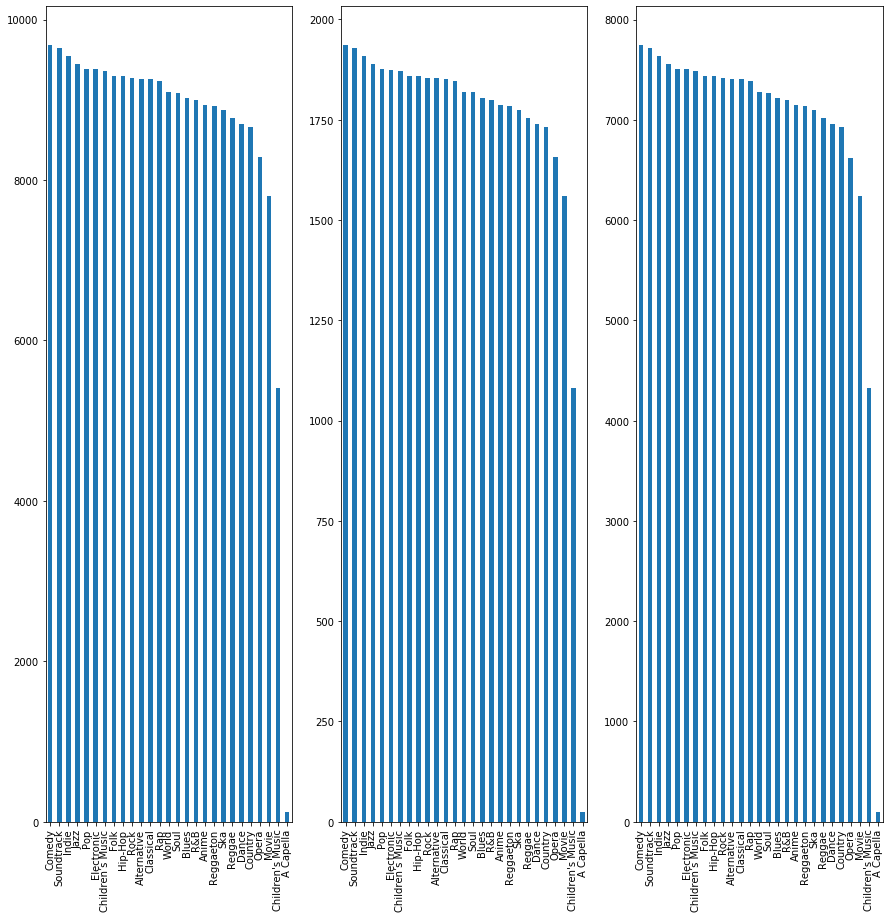

In [0]:
fig, axes = plt.subplots(ncols=3, figsize=(15,15))
df['genre'].value_counts().plot(kind='bar', ax=axes[0])
strat_test_set["genre"].value_counts().plot(kind='bar', ax=axes[1])
strat_train_set["genre"].value_counts().plot(kind='bar', ax=axes[2])
plt.show()

In [0]:
train_set = strat_train_set.copy()

In [0]:
test_set = strat_test_set.copy()

## 3. Explore the data to gain insights
In this part we will explore and visualize the data to gain insight on the features and how they are presented. Furthermore, we will also show the correlation between the different features.
### Check the data structure
#### First check the data with pandas

In [0]:
train_set.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
29633,Anime,Rozen,Ballad of the Windfish,2LIOduN0xKa3MUQ2sfXH4k,27,0.959,0.255,265280,0.192,0.815000,D,0.156,-13.698,Major,0.0328,80.006,4/4,0.0587
157325,Ska,Rancid,Hooligans,5uNrA98u8ZSoAaHaDSSmU4,40,0.180,0.411,152760,0.958,0.000002,G,0.126,-3.291,Major,0.0812,171.686,4/4,0.7770
27557,Alternative,Anthem Lights,Best of 2010: Baby / Break Even / Need You Now...,5J1iMCE9SnuOqwRwOpVxhp,47,0.709,0.417,155342,0.443,0.000000,F,0.217,-6.261,Major,0.0328,119.903,4/4,0.4700
205668,Soundtrack,Tom Tykwer,Sonmi-451 Meets Chang,7IUdZBMyYPNkl4V4oQQwn4,21,0.281,0.143,213970,0.207,0.773000,C#,0.113,-14.786,Major,0.0362,168.028,4/4,0.0646
202563,Soundtrack,Alexandre Desplat,Schloss Lutz Overture,5tI8l60GcPFS5wSsZZxfki,33,0.907,0.128,32173,0.136,0.944000,A#,0.119,-16.687,Minor,0.0363,147.175,4/4,0.1390


In [0]:
test_set.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
122173,Rap,Mike WiLL Made-It,On The Come Up (feat. Big Sean),7HwKzQBybHSHqdLv25VdtU,52,0.0391,0.494,235886,0.643,0.000,G,0.6580,-6.211,Major,0.2940,110.052,4/4,0.511
59834,R&B,Cuban Doll,Let It Blow (feat. Molly Brazy),2zG54F3cASuj6yHoYeCoK6,51,0.0145,0.730,159843,0.701,0.000,A,0.0795,-5.912,Major,0.3460,179.763,4/4,0.307
55521,Movie,Judy Kuhn,Goodby Joe,7BSkcOETKiHTVzCnKx5jdM,1,0.7910,0.794,145653,0.328,0.000,C,0.1490,-7.723,Major,0.0358,121.869,4/4,0.413
80883,Opera,Adolphe Adam,Giselle: Act I: Moderato,3gbf9PJnMLR0mNXNApx1UF,10,0.8720,0.404,62693,0.187,0.432,D#,0.1000,-23.432,Major,0.0583,173.534,4/4,0.375
66857,Hip-Hop,"Tyler, The Creator",Potato Salad,1jzIJcHCXneHw7ojC6LXiF,76,0.3080,0.538,182493,0.612,0.000,D,0.2130,-6.020,Major,0.4240,168.197,4/4,0.684


In [0]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186180 entries, 29633 to 188833
Data columns (total 18 columns):
genre               186180 non-null object
artist_name         186180 non-null object
track_name          186180 non-null object
track_id            186180 non-null object
popularity          186180 non-null int64
acousticness        186180 non-null float64
danceability        186180 non-null float64
duration_ms         186180 non-null int64
energy              186180 non-null float64
instrumentalness    186180 non-null float64
key                 186180 non-null object
liveness            186180 non-null float64
loudness            186180 non-null float64
mode                186180 non-null object
speechiness         186180 non-null float64
tempo               186180 non-null float64
time_signature      186180 non-null object
valence             186180 non-null float64
dtypes: float64(9), int64(2), object(7)
memory usage: 27.0+ MB


In [0]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46545 entries, 122173 to 185482
Data columns (total 18 columns):
genre               46545 non-null object
artist_name         46545 non-null object
track_name          46545 non-null object
track_id            46545 non-null object
popularity          46545 non-null int64
acousticness        46545 non-null float64
danceability        46545 non-null float64
duration_ms         46545 non-null int64
energy              46545 non-null float64
instrumentalness    46545 non-null float64
key                 46545 non-null object
liveness            46545 non-null float64
loudness            46545 non-null float64
mode                46545 non-null object
speechiness         46545 non-null float64
tempo               46545 non-null float64
time_signature      46545 non-null object
valence             46545 non-null float64
dtypes: float64(9), int64(2), object(7)
memory usage: 6.7+ MB


In [0]:
train_set.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,186180.000000,186180.00000,186180.000000,1.861800e+05,186180.000000,186180.000000,186180.000000,186180.000000,186180.000000,186180.000000,186180.000000
mean,41.143608,0.36852,0.554526,2.349837e+05,0.571157,0.148537,0.215042,-9.566601,0.120819,117.710782,0.455140
std,18.198913,0.35469,0.185496,1.185263e+05,0.263411,0.302839,0.198160,5.995209,0.185483,30.908803,0.260134
min,0.000000,0.00000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,29.000000,0.03750,0.435000,1.828052e+05,0.386000,0.000000,0.097400,-11.775000,0.036700,92.975000,0.237000
50%,43.000000,0.23200,0.571000,2.202270e+05,0.606000,0.000045,0.128000,-7.764000,0.050100,115.885000,0.444000
75%,55.000000,0.72200,0.692000,2.656455e+05,0.787000,0.036600,0.264000,-5.500000,0.105000,139.085000,0.660000
max,100.000000,0.99600,0.989000,5.488000e+06,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000


The describe method gives a good summary of the numerical attributes.
- std is the standard deviation
- 25%, 50%, and 75% rows show the corresponding percentiles: a percentile indicates the value below which a given percentage of observations in a group of observations fall

#### Display the data graphically using histograms

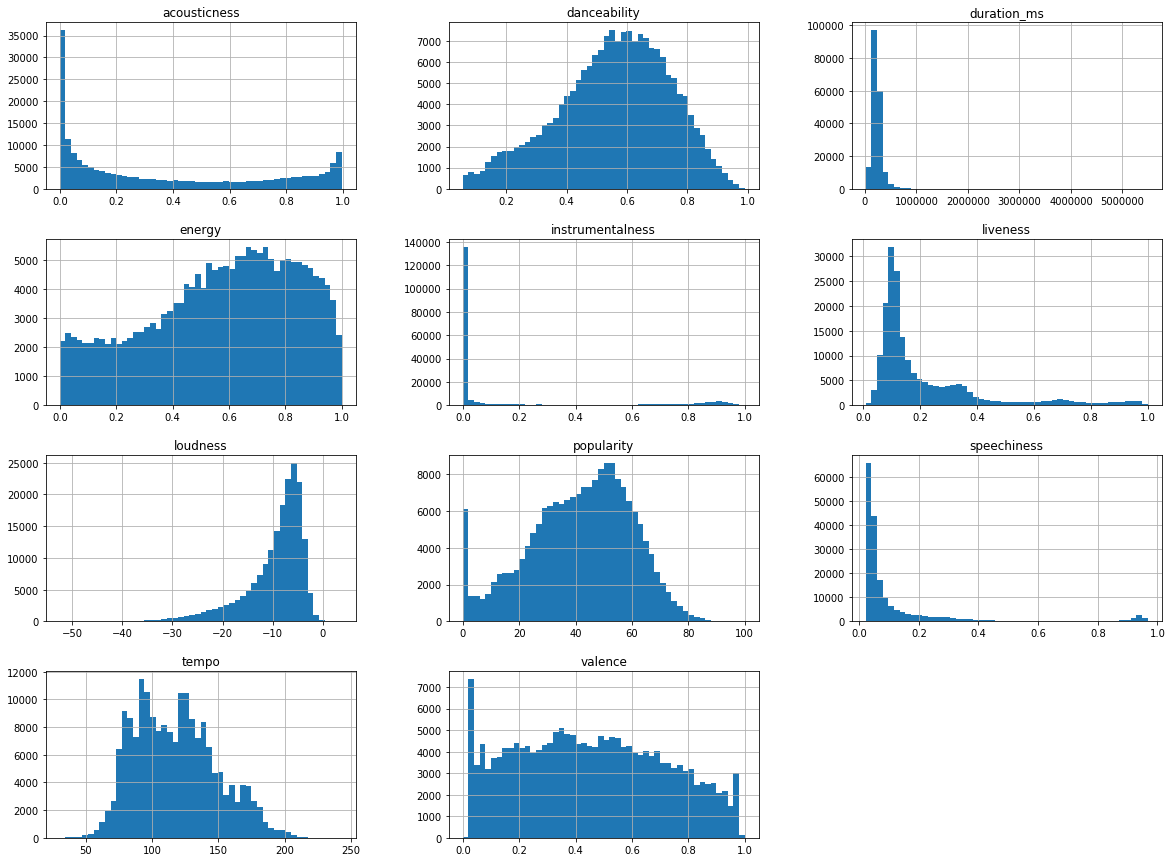

In [0]:
train_set.hist(bins=50, figsize=(20,15))
plt.show()

### Look for correlations
#### Correlation matrix
The correlation matrix gives an overview about all linear correlations between every pair of attributes. The coefficient is in the intervall from –1 to 1. 1 means there is a strong linear correlation and -1 stands for a strong negative linear correlation. Coefficients around 0 indicates no linear correlation.

In [0]:
corr_matrix = df.corr();
corr_matrix["valence"].sort_values(ascending=False)

valence             1.000000
danceability        0.547154
energy              0.436771
loudness            0.399901
tempo               0.134857
popularity          0.060076
speechiness         0.023842
liveness            0.011804
duration_ms        -0.141811
instrumentalness   -0.307522
acousticness       -0.325798
Name: valence, dtype: float64

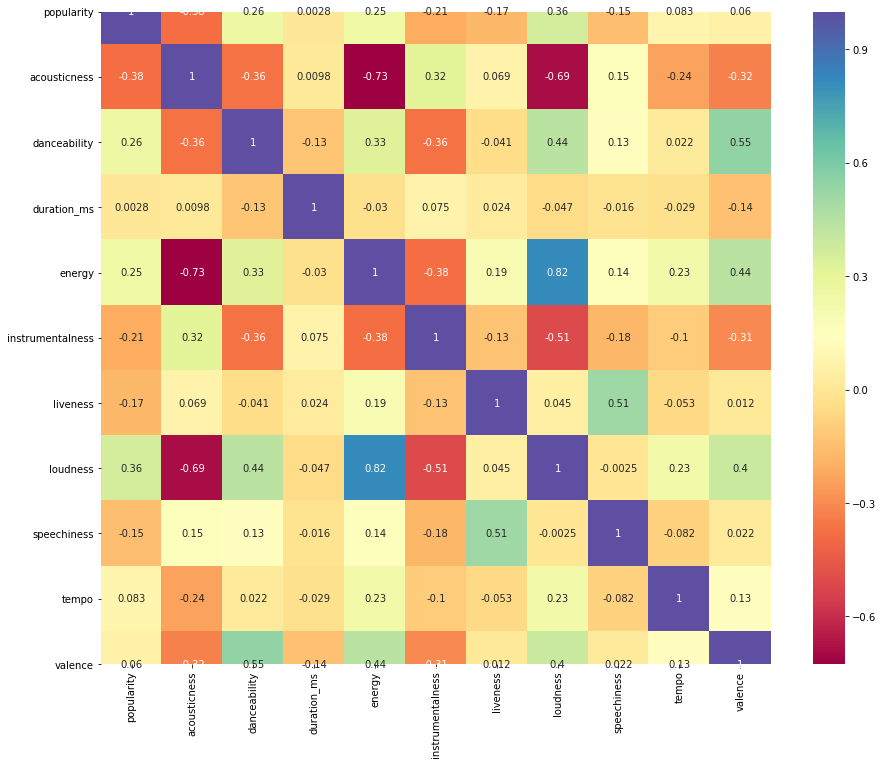

In [0]:
plt.figure(figsize=(15,12))
cor = train_set.corr()
sns.heatmap(cor, annot=True, cmap='Spectral')
plt.show()

#### Pandas scatter matrix
A more graphical way to check correlations is printing the numerical attributes against the other numerical attributes with a scatter matrix. This means there are amount_of_attributes squared options. In this case we grab four attributes that showed the best result to display the correlations between them.

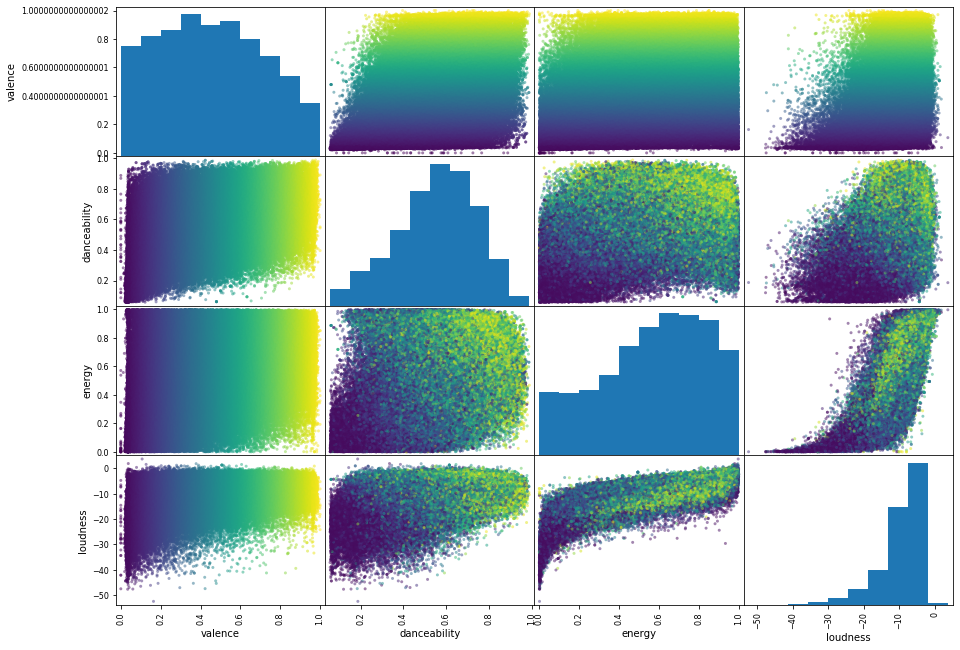

In [0]:
attributes = ["valence", "danceability", "energy","loudness"]
scatter_matrix(df[attributes], figsize=(15, 11), c=df["valence"])
plt.show()

## 4. Prepare the data to better expose the underlying data patterns to machine learning algorithms
In this part we will prepare the data so with can use it to train our models. The data should be prepared in a way that we will get an optimal performance for our models.

*Start with a fresh copy of the training dataset*

In [0]:
train_set = strat_train_set.copy()

### Null values
*Check for null values*

In [0]:
train_set.isnull().sum()

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

Since there are no null values we don't have to worry about them.

### Handling text

This dataframe seems to have 3 important categorical attributes (mode, time signature and key). These are not very useable for a machine learning model so they will need to be converted to numerical values if we would want to use them.

#### Mode

Since mode only has two values, Minor and Major, we could easily convert this to numerical values. This will be 1 for Major and 0 for Minor.

In [0]:
train_set["mode"].value_counts()

Major    121417
Minor     64763
Name: mode, dtype: int64

In [0]:
class ModeEncoder(BaseEstimator,TransformerMixin):
    def fit (self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        X.loc[X["mode"] == 'Major', "mode"] = 1
        X.loc[X["mode"] == 'Minor', "mode"] = 0
        return X

In [0]:
train_mode_numeric = ModeEncoder().fit_transform(train_set)

In [0]:
train_mode_numeric.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
29633,Anime,Rozen,Ballad of the Windfish,2LIOduN0xKa3MUQ2sfXH4k,27,0.959,0.255,265280,0.192,0.815000,D,0.156,-13.698,1,0.0328,80.006,4/4,0.0587
157325,Ska,Rancid,Hooligans,5uNrA98u8ZSoAaHaDSSmU4,40,0.180,0.411,152760,0.958,0.000002,G,0.126,-3.291,1,0.0812,171.686,4/4,0.7770
27557,Alternative,Anthem Lights,Best of 2010: Baby / Break Even / Need You Now...,5J1iMCE9SnuOqwRwOpVxhp,47,0.709,0.417,155342,0.443,0.000000,F,0.217,-6.261,1,0.0328,119.903,4/4,0.4700
205668,Soundtrack,Tom Tykwer,Sonmi-451 Meets Chang,7IUdZBMyYPNkl4V4oQQwn4,21,0.281,0.143,213970,0.207,0.773000,C#,0.113,-14.786,1,0.0362,168.028,4/4,0.0646
202563,Soundtrack,Alexandre Desplat,Schloss Lutz Overture,5tI8l60GcPFS5wSsZZxfki,33,0.907,0.128,32173,0.136,0.944000,A#,0.119,-16.687,0,0.0363,147.175,4/4,0.1390


#### Time signature
Time signature is another categorical feature with not too many unique values that we could transform into numerical values. 

In [0]:
train_set['time_signature'].value_counts()

4/4    160548
3/4     19296
5/4      4220
1/4      2109
0/4         7
Name: time_signature, dtype: int64

In [0]:
test_set['time_signature'].value_counts()

4/4    40212
3/4     4815
5/4     1018
1/4      499
0/4        1
Name: time_signature, dtype: int64

An extremely low amount of songs, 8 in total in the whole dataset, seem to be with a time signature of **0/4**, we could remove these values.

In [0]:
class RemoveZeroFour(BaseEstimator,TransformerMixin):
    def fit (self,X,y=None):
        return self
    def transform(self,X,y=None):
        X = X[X.time_signature != '0/4']
        return X

In [0]:
cat_encoder = OneHotEncoder(sparse=False)
train_sig = train_set[['time_signature']]
train_sig = RemoveZeroFour().fit_transform(train_sig)
train_cat_1hot = cat_encoder.fit_transform(train_sig)

In [0]:
cat_encoder.categories_

[array(['1/4', '3/4', '4/4', '5/4'], dtype=object)]

In [0]:
train_cat_1hot

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

In [0]:
class TimeSignatureEncoder(BaseEstimator,TransformerMixin):
    def __init__(self, cat_encoder = OneHotEncoder(sparse = False)):
      self.cat_encoder = cat_encoder
    def fit (self,X,y=None):
      return self
    def transform(self,X,y=None):
      cat = cat_encoder.fit_transform(X[['time_signature']])
      Y = pd.DataFrame(data=cat, columns=['1/4', '3/4', '4/4', '5/4'])
      X = X.drop('time_signature', axis=1)
      X = pd.concat([X, Y], axis=1, sort=False)
      return X

In [0]:
train_sig = RemoveZeroFour().fit_transform(train_set)
train_time_signature = TimeSignatureEncoder().fit_transform(train_sig)

In [0]:
train_time_signature.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,1/4,3/4,4/4,5/4
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0.0,0.611,0.389,99373.0,0.910,0.000,C#,0.3460,-1.828,1.0,0.0525,166.969,0.814,0.0,0.0,1.0,0.0
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1.0,0.246,0.590,137373.0,0.737,0.000,F#,0.1510,-5.559,0.0,0.0868,174.003,0.816,0.0,0.0,1.0,0.0
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3.0,0.952,0.663,170267.0,0.131,0.000,C,0.1030,-13.879,0.0,0.0362,99.488,0.368,0.0,0.0,1.0,0.0
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0.0,0.703,0.240,152427.0,0.326,0.000,C#,0.0985,-12.178,1.0,0.0395,171.758,0.227,0.0,0.0,1.0,0.0
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4.0,0.950,0.331,82625.0,0.225,0.123,F,0.2020,-21.150,1.0,0.0456,140.576,0.390,0.0,0.0,1.0,0.0


#### Key

In [0]:
train_set['key'].value_counts()

C     22095
G     21030
D     19257
C#    18587
A     18157
F     16223
B     14124
E     13899
A#    12345
F#    12235
G#    12176
D#     6052
Name: key, dtype: int64

For the key we tried two transformations: transforming the key to integer numbers from 0 to 11 and transforming it to a boolean attrribute. The second version gave slightly better results but it added too many features so we stuck with the first solution.

In [0]:
class KeyEncoder(BaseEstimator,TransformerMixin):
    def fit (self,X,y=None):
        return self
    
    def transform(self,X,y=None):
      list_of_keys = X['key'].unique()
      for i in range(len(list_of_keys)):
        X.loc[X['key'] == list_of_keys[i], 'key'] = i
      return X

In [0]:
class KeyFullEncoder(BaseEstimator,TransformerMixin):
    cat_encoder = OneHotEncoder(sparse = False)
    def fit (self,X,y=None):
      return self
    def transform(self,X,y=None):
      cat = cat_encoder.fit_transform(X[['key']])
      Y = pd.DataFrame(data=cat, columns=['C', 'G', 'D', 'C#','A','F','B','E','A#','F#','G#','D#'])
      Z = X.drop('key', axis=1)
      A = pd.concat([Z, Y], axis=1, sort=False)
      return A

In [0]:
train_key = KeyEncoder().fit_transform(train_set)

In [0]:
train_key.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
29633,Anime,Rozen,Ballad of the Windfish,2LIOduN0xKa3MUQ2sfXH4k,27,0.959,0.255,265280,0.192,0.815000,0,0.156,-13.698,1,0.0328,80.006,4/4,0.0587
157325,Ska,Rancid,Hooligans,5uNrA98u8ZSoAaHaDSSmU4,40,0.180,0.411,152760,0.958,0.000002,1,0.126,-3.291,1,0.0812,171.686,4/4,0.7770
27557,Alternative,Anthem Lights,Best of 2010: Baby / Break Even / Need You Now...,5J1iMCE9SnuOqwRwOpVxhp,47,0.709,0.417,155342,0.443,0.000000,2,0.217,-6.261,1,0.0328,119.903,4/4,0.4700
205668,Soundtrack,Tom Tykwer,Sonmi-451 Meets Chang,7IUdZBMyYPNkl4V4oQQwn4,21,0.281,0.143,213970,0.207,0.773000,3,0.113,-14.786,1,0.0362,168.028,4/4,0.0646
202563,Soundtrack,Alexandre Desplat,Schloss Lutz Overture,5tI8l60GcPFS5wSsZZxfki,33,0.907,0.128,32173,0.136,0.944000,4,0.119,-16.687,0,0.0363,147.175,4/4,0.1390


Here we are going to test all the text handling classes before combining them in a pipeline. This will give us a quick look at the final features we will use for our models.

In [0]:
test = train_set.copy()

In [0]:
test = ModeEncoder().fit_transform(test)
test = KeyEncoder().fit_transform(test)
test = RemoveZeroFour().fit_transform(test)
test = TimeSignatureEncoder().fit_transform(test)
test.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,1/4,3/4,4/4,5/4
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0.0,0.611,0.389,99373.0,0.910,0.000,3.0,0.3460,-1.828,1.0,0.0525,166.969,0.814,0.0,0.0,1.0,0.0
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1.0,0.246,0.590,137373.0,0.737,0.000,6.0,0.1510,-5.559,0.0,0.0868,174.003,0.816,0.0,0.0,1.0,0.0
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3.0,0.952,0.663,170267.0,0.131,0.000,5.0,0.1030,-13.879,0.0,0.0362,99.488,0.368,0.0,0.0,1.0,0.0
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0.0,0.703,0.240,152427.0,0.326,0.000,3.0,0.0985,-12.178,1.0,0.0395,171.758,0.227,0.0,0.0,1.0,0.0
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4.0,0.950,0.331,82625.0,0.225,0.123,2.0,0.2020,-21.150,1.0,0.0456,140.576,0.390,0.0,0.0,1.0,0.0


### Remove outliers
Outliers are anomalies in the data set that are for example way bigger or way smaller than most of the other values. Removing these can also improve the performance of our model.

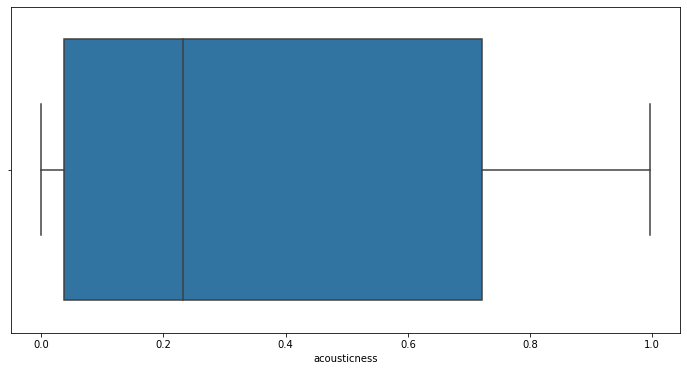

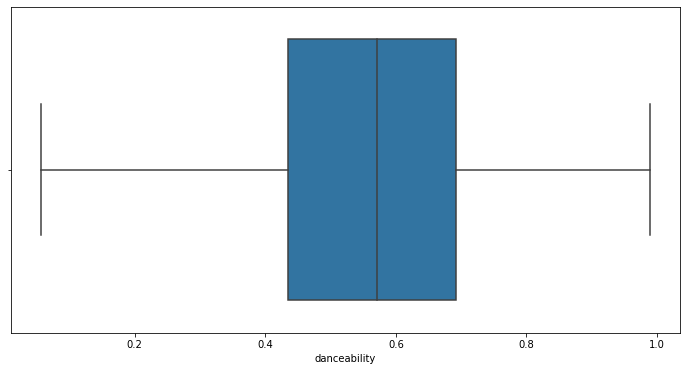

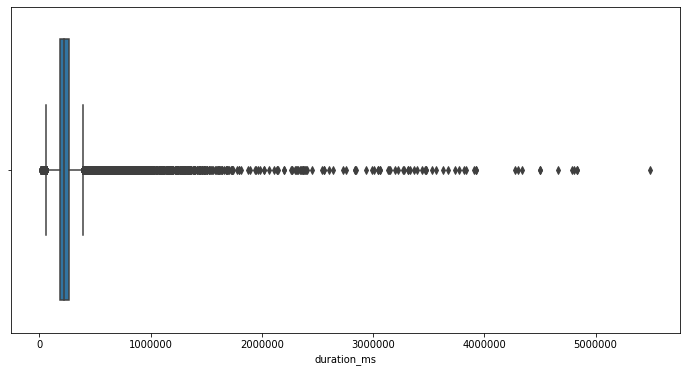

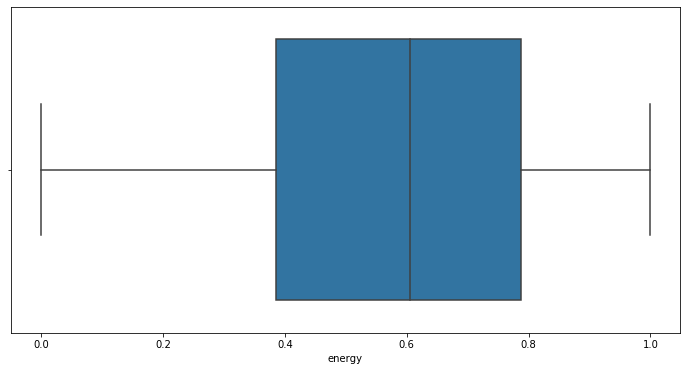

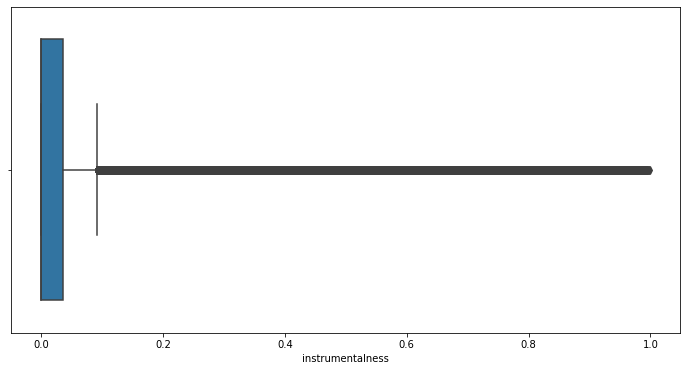

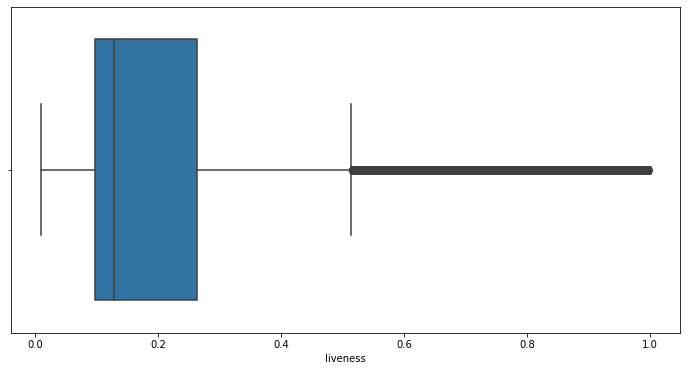

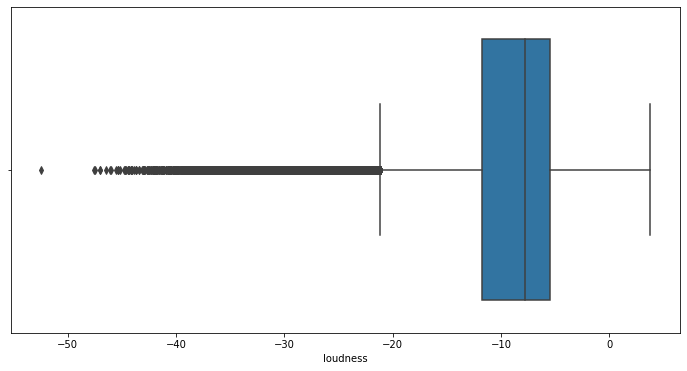

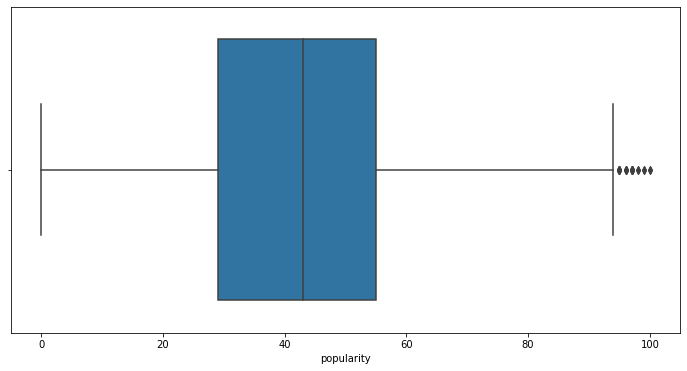

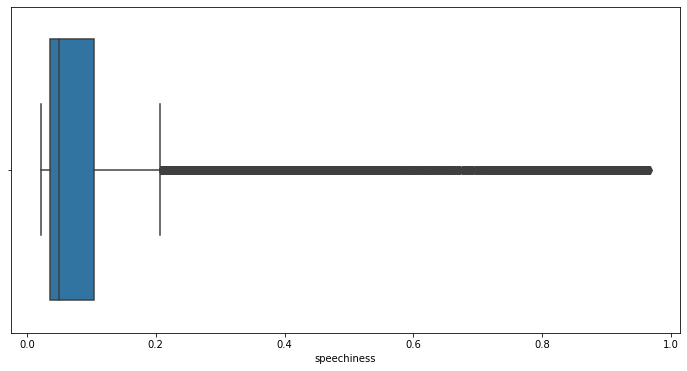

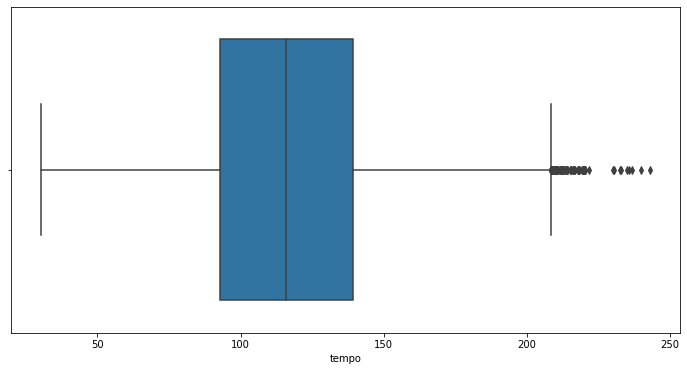

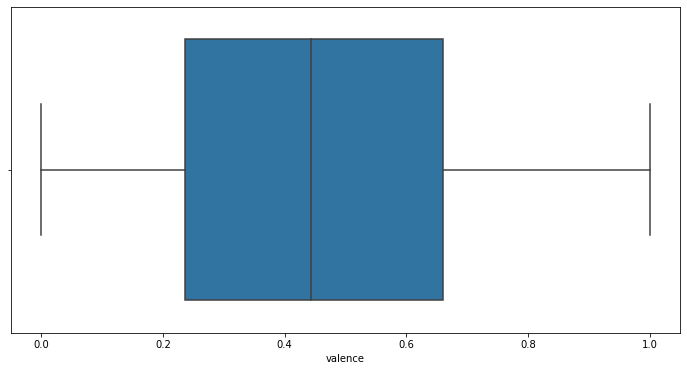

In [0]:
 num_features=['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'popularity', 'speechiness', 'tempo', 'valence']

for i in num_features:
    fig, ax = plt.subplots()
    fig.set_size_inches(12,6)
    sns.boxplot(x=i,data=train_set,ax=ax)
    plt.show()
    

To clean our train set we use the method below to remove outliers. According to a mathematical theory (the 68-95-99.7 rule), everything outside -3 times the standard deviation and 3 times the standard deviation is an outlier.

In [0]:
class RemoveOutliers(BaseEstimator,TransformerMixin):
    def fit (self,X,y=None):
        return self
    
    def transform(self,X,y=None):
      min_quartiles = []
      max_quartiles = []
      
      for i in num_features:
        q1 = np.percentile(X[i], 25)
        q3 = np.percentile(X[i], 75)
        iqr = q3-q1
  
        qmin = q1-(1.5*iqr)
        qmax = q3+(1.5*iqr)
  
        min_quartiles.append(qmin)
        max_quartiles.append(qmax)
      
      for i in range(len(num_features)):
        X = X[X[num_features[i]] <= max_quartiles[i]].reset_index(drop=True)
        X = X[X[num_features[i]] >= min_quartiles[i]].reset_index(drop=True)
      return X

In [0]:
train_removed_outliers = RemoveOutliers().fit_transform(train_set)

In [0]:
train_removed_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107153 entries, 0 to 107152
Data columns (total 18 columns):
genre               107153 non-null object
artist_name         107153 non-null object
track_name          107153 non-null object
track_id            107153 non-null object
popularity          107153 non-null int64
acousticness        107153 non-null float64
danceability        107153 non-null float64
duration_ms         107153 non-null int64
energy              107153 non-null float64
instrumentalness    107153 non-null float64
key                 107153 non-null int64
liveness            107153 non-null float64
loudness            107153 non-null float64
mode                107153 non-null int64
speechiness         107153 non-null float64
tempo               107153 non-null float64
time_signature      107153 non-null object
valence             107153 non-null float64
dtypes: float64(9), int64(4), object(5)
memory usage: 14.7+ MB


We can see by removing outliers we decreased the dataset size.

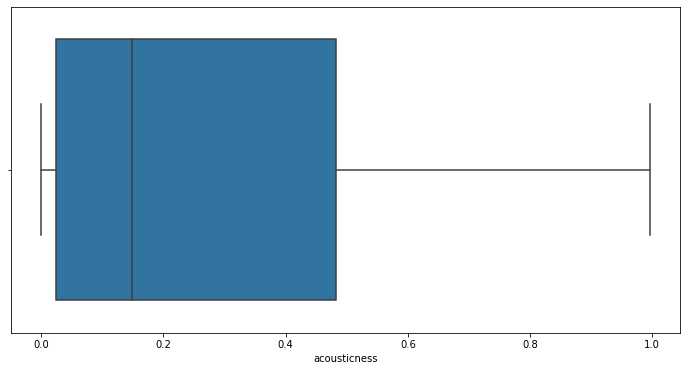

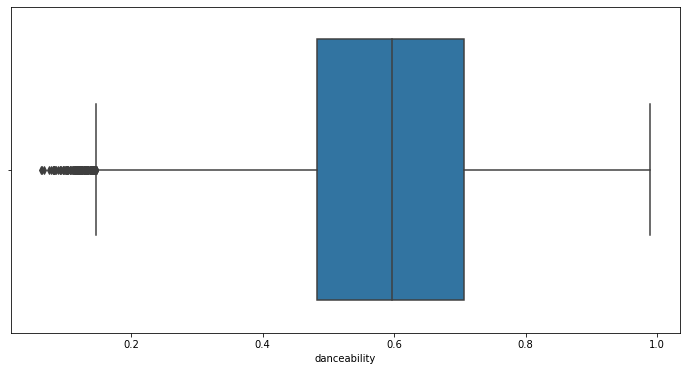

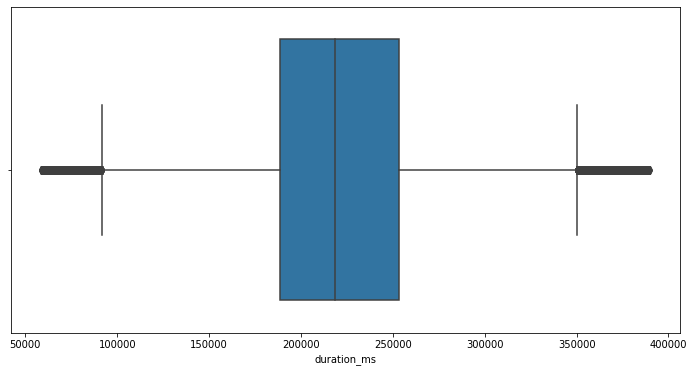

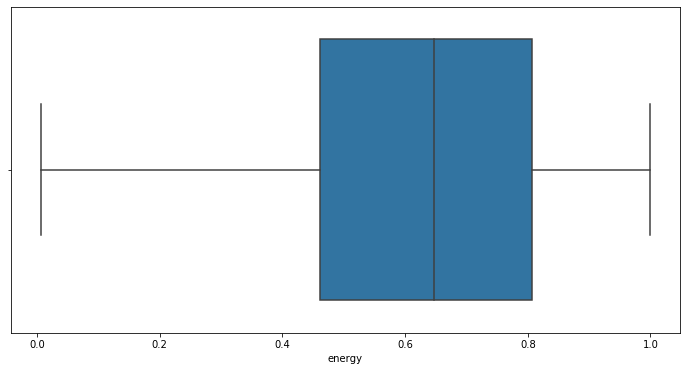

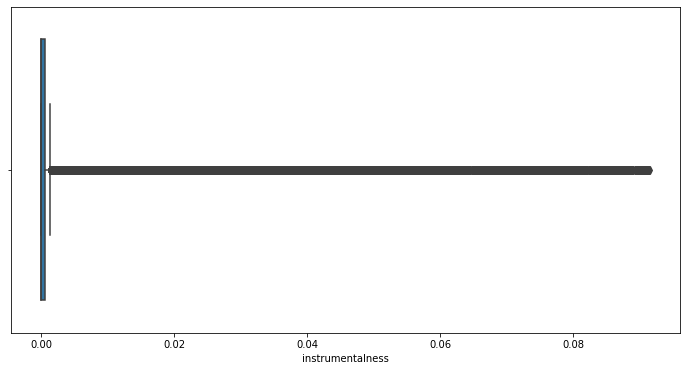

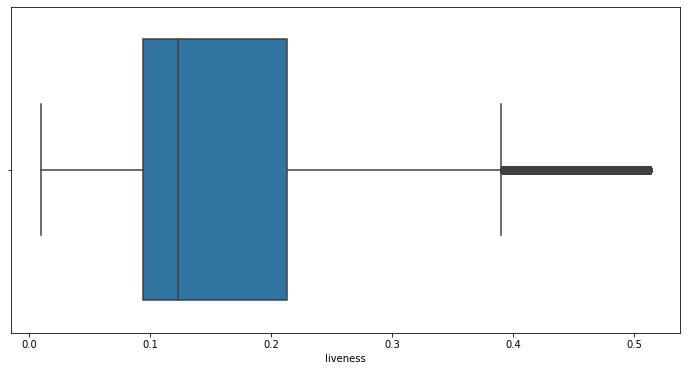

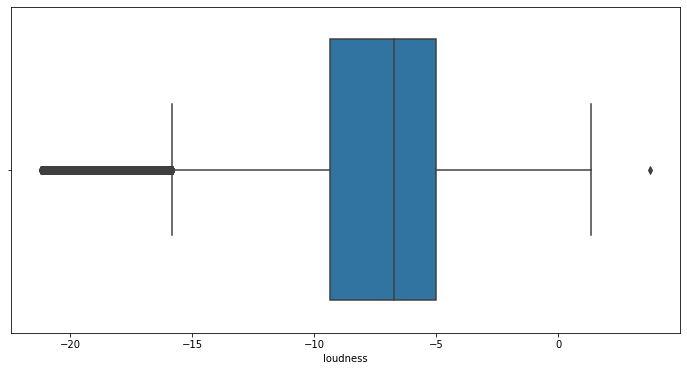

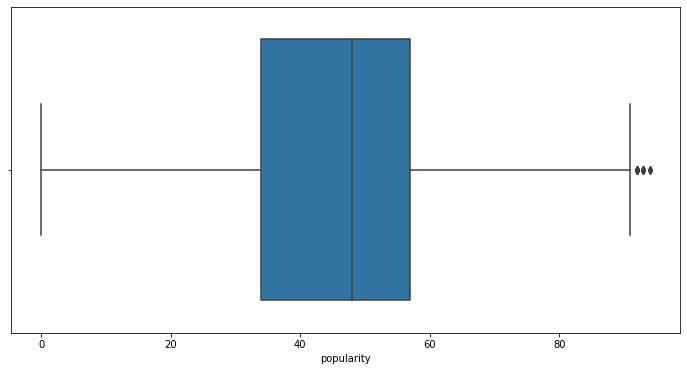

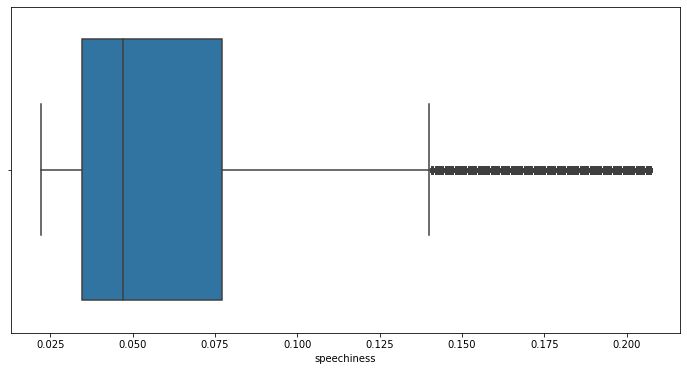

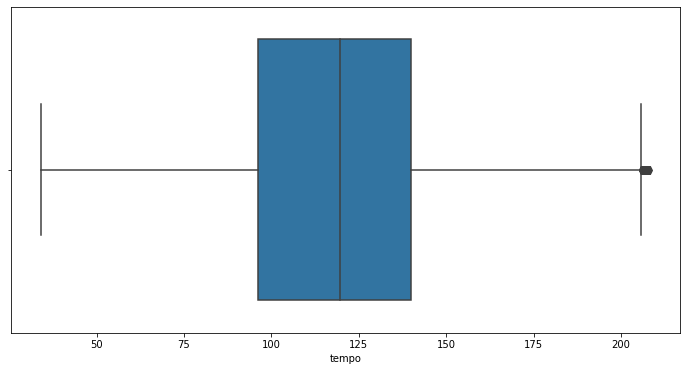

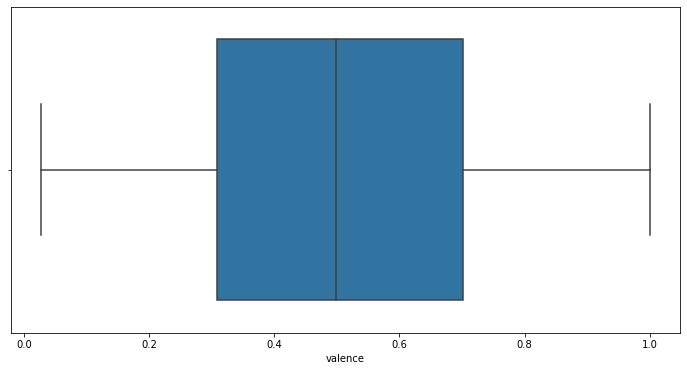

In [0]:
for i in num_features:
    fig, ax = plt.subplots()
    fig.set_size_inches(12,6)
    sns.boxplot(x=i,data=train_removed_outliers,ax=ax)
    plt.show()

### Pipelines
Of course we would like to automate all of the previous parts in one big pipeline for easy use

*Start with a fresh dataset*

In [0]:
train_set = strat_train_set.copy()

In [0]:
class ColumnSelector(BaseEstimator,TransformerMixin):
    def __init__(self,features):
        self.features=features
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X[self.features]

In [0]:
song_columns = ['genre','artist_name','track_name','track_id']
data_columns = ['popularity','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','mode','C', 'G', 'D', 'C#','A','F','B','E','A#','F#','G#','D#','1/4','3/4','4/4','5/4']
data2_columns = ['popularity','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','key','mode','1/4','3/4','4/4','5/4']
num_columns = ['popularity','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo']
cat_columns = ['key','mode', 'time_signature']

These pipelines are doing all the transformation and scaling work.

In [0]:
prep_pipeline = Pipeline([
    ('rem_0/4', RemoveZeroFour()),
    ('rem_out', RemoveOutliers())
])

num_pipeline = Pipeline([
    ('num_select', ColumnSelector(num_columns)),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('cat_select', ColumnSelector(cat_columns)),
    ('mode_encoder', ModeEncoder()),
    ('key_encoder', KeyEncoder()),
    ('time_sig_encoder', TimeSignatureEncoder())
])

num_cat_pipeline=FeatureUnion(transformer_list=[
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline),  
])


We also made a function to combine the different parts of the pipelines and getting the labels into one line.

In [0]:
def DataSetPreparer(set, test=False):
  set_prep = prep_pipeline.fit_transform(set)
  set_labels, set_scaled_labels = LabelExtractor(set_prep)

  if not test:
    set_prep = num_cat_pipeline.fit_transform(set_prep)
  else:
    set_prep = num_cat_pipeline.transform(set_prep)

  set_prep = pd.DataFrame(set_prep, columns = data2_columns)
  set_prep = set_prep.astype('float', copy=False)
  
  return set_prep, set_labels, set_scaled_labels


def LabelExtractor(set):
  label_scaler=StandardScaler()

  set_labels = set['valence']
  
  y_train = set_labels.copy()
  set_scaled_labels=label_scaler.fit_transform(y_train.values.reshape(-1,1))
  
  return set_labels, set_scaled_labels

In [0]:
train_prepared, train_labels, train_scaled_labels = DataSetPreparer(train_set)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_laun

In [0]:
train_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107153 entries, 0 to 107152
Data columns (total 16 columns):
popularity          107153 non-null float64
acousticness        107153 non-null float64
danceability        107153 non-null float64
duration_ms         107153 non-null float64
energy              107153 non-null float64
instrumentalness    107153 non-null float64
liveness            107153 non-null float64
loudness            107153 non-null float64
speechiness         107153 non-null float64
tempo               107153 non-null float64
key                 107153 non-null float64
mode                107153 non-null float64
1/4                 107153 non-null float64
3/4                 107153 non-null float64
4/4                 107153 non-null float64
5/4                 107153 non-null float64
dtypes: float64(16)
memory usage: 13.1 MB


In [0]:
train_prepared.head(10)

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,key,mode,1/4,3/4,4/4,5/4
0,-0.271487,-0.330660,-1.124939,-1.286767,1.480488,-0.315799,-0.376805,1.191360,0.421293,1.734462,0.0,1.0,0.0,0.0,1.0,0.0
1,0.125132,1.398011,-1.086988,-1.238772,-0.785976,-0.315918,0.532922,0.363361,-0.744798,-0.019710,1.0,1.0,0.0,0.0,1.0,0.0
2,0.635071,-0.500587,-1.365293,1.247212,0.283443,-0.315765,2.192424,0.569942,-0.715887,-0.905215,2.0,1.0,0.0,0.0,1.0,0.0
3,0.521752,1.244424,0.374116,0.181201,-0.425102,4.588749,-0.596739,0.464561,-0.291854,-1.080046,3.0,1.0,0.0,1.0,0.0,0.0
4,-0.271487,1.280370,0.215988,0.257321,-0.962012,-0.314158,0.502931,-0.239936,-0.831532,0.208847,4.0,1.0,0.0,0.0,1.0,0.0
5,-1.064726,0.025531,0.260264,1.172859,-0.029021,-0.315833,-0.870657,0.489930,-0.431592,2.550793,2.0,1.0,0.0,0.0,1.0,0.0
6,1.428310,-0.487515,1.708717,-0.515903,-0.918003,-0.315918,1.702571,0.046100,2.849847,-0.184616,5.0,1.0,0.0,0.0,1.0,0.0
7,0.408432,-0.918481,-1.561372,-0.091492,1.242840,1.731586,-0.813674,0.964984,1.621114,1.343302,5.0,0.0,0.0,0.0,1.0,0.0
8,0.578411,-0.791422,-0.726456,-1.350042,0.635515,-0.315918,-0.296829,1.090160,-0.087065,1.336832,6.0,0.0,0.0,0.0,1.0,0.0
9,-0.611447,-0.646004,-1.637274,-0.587841,-0.671552,-0.313294,-0.806676,-1.340031,-0.665292,-1.053115,7.0,0.0,0.0,0.0,1.0,0.0


In [0]:
train_prepared.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,key,mode,1/4,3/4,4/4,5/4
count,1.071530e+05,1.071530e+05,1.071530e+05,1.071530e+05,1.071530e+05,1.071530e+05,1.071530e+05,1.071530e+05,1.071530e+05,1.071530e+05,107153.000000,107153.000000,107153.000000,107153.000000,107153.000000,107153.000000
mean,-1.032670e-16,-6.638461e-17,-5.292844e-16,-9.740264e-17,-2.159461e-16,3.146925e-15,-1.511374e-16,-2.807154e-16,9.871850e-17,-9.261291e-16,4.812054,0.673336,0.005282,0.068155,0.915868,0.010695
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,3.334548,0.468995,0.072487,0.252013,0.277587,0.102863
min,-2.537884e+00,-9.188613e-01,-3.325449e+00,-3.037261e+00,-2.705252e+00,-3.159176e-01,-1.534457e+00,-3.796150e+00,-1.000182e+00,-2.924395e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.114468e-01,-8.384780e-01,-6.758548e-01,-6.193668e-01,-7.023584e-01,-3.159176e-01,-6.897109e-01,-4.933535e-01,-6.990221e-01,-8.210681e-01,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.817921e-01,-4.352303e-01,5.153443e-02,-6.240062e-02,1.118082e-01,-3.153874e-01,-4.067958e-01,2.301002e-01,-4.002714e-01,-2.838258e-02,5.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,6.917313e-01,6.562180e-01,7.409729e-01,5.810019e-01,8.159523e-01,-2.740333e-01,4.929342e-01,7.101724e-01,3.249218e-01,6.617958e-01,8.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,2.788148e+00,2.335872e+00,2.530983e+00,3.121673e+00,1.660925e+00,6.807527e+00,3.492034e+00,3.152630e+00,3.452167e+00,2.972644e+00,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000



After all the transformation and scaling is done, our data looks like this:

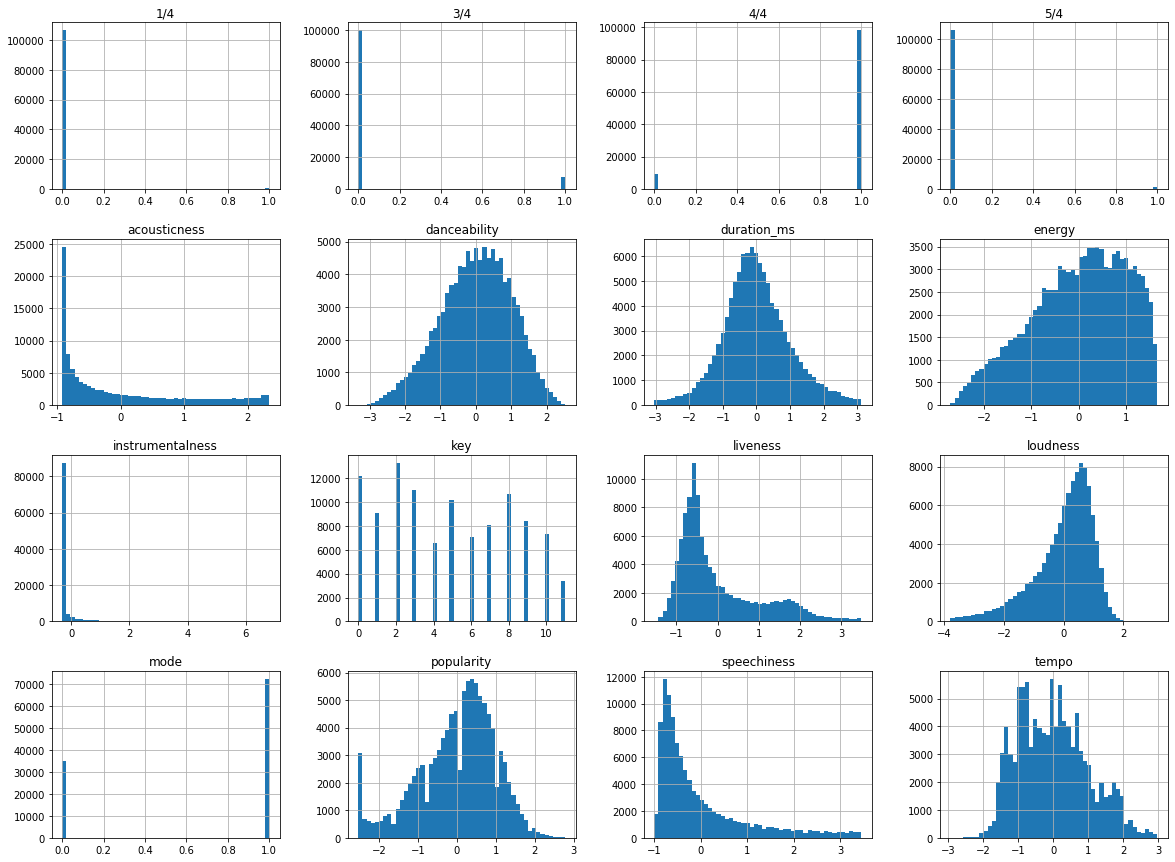

In [0]:
train_prepared.hist(bins=50, figsize=(20,15))
plt.show()

## 5. Explore many different models and short-list the best ones
In this part we will explore a few different basic models to see how they perform on our prepared data. In the next chaper we will finetune them.

In [0]:
def display_scores(model, cv_amount, scoring="neg_mean_squared_error", data=train_prepared, labels=train_labels):
    score_labels = labels
    rmseMinus = 1
    
    if scoring == "neg_mean_squared_error":
      rmseMinus = -1
    else:
      score_labels = train_scaled_labels
        
    cv = cross_val_score(model, data, score_labels, scoring=scoring, cv=cv_amount, verbose=3, n_jobs=-1)
    cv_scores = np.sqrt(cv * rmseMinus)
    
    print("-----------------------")
    print("Scoring:", scoring)
    print('Scores:',  cv_scores)
    print('Mean:',cv_scores.mean())
    print('Standard deviation:', cv_scores.std())
    print("-----------------------")

### Linear Regression

In [0]:
lin_reg = LinearRegression()

In [0]:
display_scores(lin_reg, 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-----------------------
Scoring: neg_mean_squared_error
Scores: [0.19179578 0.19056253 0.1903828  0.19083671 0.18975125]
Mean: 0.19066581574280367
Standard deviation: 0.0006683153605210854
-----------------------


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


### Decision Tree Regressor

In [0]:
tree_reg = DecisionTreeRegressor(random_state=42)

In [0]:
display_scores(tree_reg, 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.0s


-----------------------
Scoring: neg_mean_squared_error
Scores: [0.20346036 0.20325479 0.20252704 0.19974273 0.19981145]
Mean: 0.20175927445296046
Standard deviation: 0.001648041820501191
-----------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


### Random Forest Regressor

In [0]:
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)

In [0]:
display_scores(forest_reg, 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.5s remaining:   23.2s


-----------------------
Scoring: neg_mean_squared_error
Scores: [0.15352524 0.1535905  0.15215411 0.1530545  0.15201869]
Mean: 0.15286860974572236
Standard deviation: 0.0006662901399491204
-----------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.4s finished


### Gradient Boosting Regressor

In [0]:
gb_reg = GradientBoostingRegressor(random_state=42)

In [0]:
display_scores(gb_reg, 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   18.4s remaining:   27.6s


-----------------------
Scoring: neg_mean_squared_error
Scores: [0.18018168 0.1794424  0.17882192 0.17878663 0.17842053]
Mean: 0.17913063175639904
Standard deviation: 0.0006196410750309768
-----------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.1s finished


### Extra Trees Regressor

In [0]:
extra_reg = ExtraTreesRegressor()

In [0]:
display_scores(extra_reg, 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.6s remaining:   11.4s


-----------------------
Scoring: neg_mean_squared_error
Scores: [0.1480154  0.14975489 0.14880928 0.14812894 0.1472626 ]
Mean: 0.14839422075550407
Standard deviation: 0.0008388273955040721
-----------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.0s finished


### Support Vector Machine

In [0]:
SVM2 = LinearSVR()

In [0]:
display_scores(SVM2,5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   27.2s remaining:   40.7s


-----------------------
Scoring: neg_mean_squared_error
Scores: [0.1939696  0.19534059 0.19187362 0.19443817 0.19102625]
Mean: 0.1933296448205542
Standard deviation: 0.0016191305837850625
-----------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.5s finished


### XGBoost

In [0]:
xgb = XGBRegressor(random_state=42, tree_method="gpu_hist") #Uses GPU for faster calculation (we used the Google Colab one with 12GB VRAM, it might be slower on others)

In [0]:
display_scores(xgb, 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.0s remaining:   12.0s


-----------------------
Scoring: neg_mean_squared_error
Scores: [0.18003832 0.17957369 0.17898093 0.17872246 0.17845518]
Mean: 0.17915411623316543
Standard deviation: 0.0005766604237105325
-----------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s finished


## 6. Fine-tune your models and combine them into a great solution
In this part we will fine-tune our models and try to gain insight on which parameters will give the best performance for them.



### Functions to help get a clear overview

#### Feature Importances
It is important to see which features are the most important according to our models to make their predictions. This can be useful to later train the models with only the most important features for a possible better performance

In [0]:
def plot_feature_importances(model, labels=train_labels,data=train_prepared):
    name = type(model).__name__
    
    model.fit(data, labels)
    
    feat_importances = pd.DataFrame({"Importance" : model.feature_importances_, "Feature" : data.columns})
    feat_importances = feat_importances.sort_values(by=['Importance'], ascending=False)
    
    sns.set_context("notebook")
    ax = sns.catplot(y="Feature", x="Importance", data=feat_importances, kind="bar", palette="muted")
    axes = ax.axes.flatten()
    axes[0].set_title('Feature importances %s' % name, fontsize=16)
    plt.show()

#### Validation curve
With a validation curve we can get a clear overview on how the values will influence our score on both a training and data set. This is done to avoid overfitting on the training set which will result in worse performance on the testing set

In [0]:
"""
This function plots the validation curve.
    
scores: scores obtained from validation_curve() method
param_range: list of range of parameters passed as 'param_range' in validation_curve() method
scoring: the scoring method
"""
    
def plot_validation_curve(scores,param_range,param_name,scoring='r2'):
    n=len(param_range)
    if scoring=='r2':
        train_score=[scores[0][i].mean() for i in range (0,n)]
        test_score=[scores[1][i].mean() for i in range (0,n)]
    elif scoring=='neg_mean_squared_error':
        train_score=[np.sqrt(-scores[0][i].mean()) for i in range (0,n)]
        test_score=[np.sqrt(-scores[1][i].mean()) for i in range (0,n)]

    fig, axs =plt.subplots(figsize=(8,6))
    sns.lineplot(param_range,train_score,label='Train', color="royalblue", ax=axs, sort=False, marker="o")
    sns.lineplot(param_range,test_score,label='Test', color="gold", ax=axs, sort=False, marker="o")
    axs.xticks=param_range
    axs.set_title("Validation curve of {}".format(param_name),size=12)
    axs.legend(loc="upper left")
    plt.show()

### Decision Tree Regressor


#### Improving Parameters

##### Max_depth

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    7.3s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  34 out of  50 | elapsed:   11.8s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.1s finished


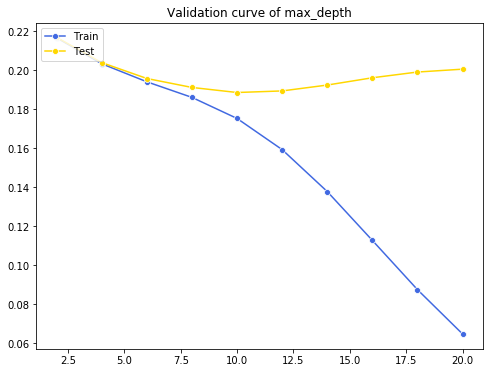

In [0]:
dtr=DecisionTreeRegressor(random_state=42)

param_name='max_depth'
param_range = range(2,21,2)
scoring='neg_mean_squared_error'

curve=validation_curve(dtr,train_prepared,train_labels,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1, verbose=3)

plot_validation_curve(curve,param_range,param_name,scoring)

We want to have a small score as possible for train and especially test data. Here we can see the more we increase max_depth, the more the test error score is decreasing. However, we can see that the two curves diverge greatly after we exceed approximately 10 for max_depth. It is clearly a sign that the model is overfitting to the training set. So we have to take a reasonable value that will not trigger overfitting and gives the lowest mean squared error. 10 seems to be a good compromise here for **max_depth**.

##### Max_features

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  75 | elapsed:    5.9s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  50 out of  75 | elapsed:   10.2s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   14.9s finished


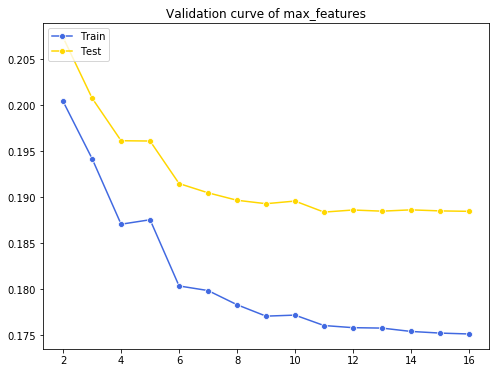

In [0]:
dtr=DecisionTreeRegressor(max_depth=10,random_state=42)

param_name='max_features'
param_range = range(2,17) 
scoring='neg_mean_squared_error'

curve=validation_curve(dtr,train_prepared,train_labels,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1, verbose=3)

plot_validation_curve(curve,param_range,param_name,scoring)

Following the same process than before we determine that the best value for **max_features** seems to be between 11 and 14.

##### Min_samples_split

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of 105 | elapsed:   10.7s remaining:   22.3s
[Parallel(n_jobs=-1)]: Done  70 out of 105 | elapsed:   19.1s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   27.0s finished


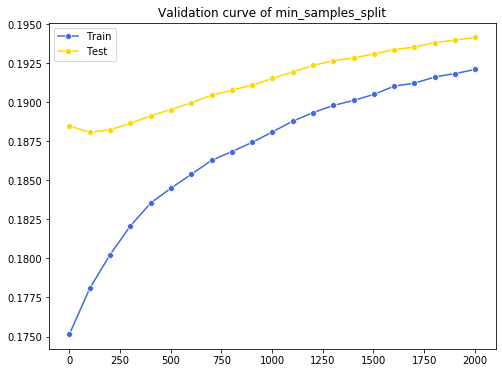

In [0]:
dtr=DecisionTreeRegressor(max_depth=10,random_state=42)

param_name='min_samples_split'
param_range = range(2,2003,100)
scoring='neg_mean_squared_error'

curve=validation_curve(dtr,train_prepared,train_labels,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1, verbose=3)

plot_validation_curve(curve,param_range,param_name,scoring)

Somewhere between 250 and 500 seems to be the best value for **min_samples_split**. In this range it will not try to overfit too much to the training data while still having a reasonable error score.

##### Min_samples_leaf

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:    4.2s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:    6.8s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.5s finished


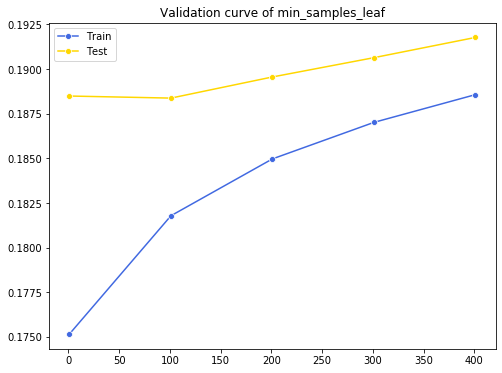

In [0]:
dtr=DecisionTreeRegressor(max_depth=10,random_state=42)

param_name='min_samples_leaf'
param_range = range(1,501,100)
scoring='neg_mean_squared_error'

curve=validation_curve(dtr,train_prepared,train_labels,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1, verbose=3)

plot_validation_curve(curve,param_range,param_name,scoring)

Changing **min_samples_leaf** doesnt seem to have much of a good influence, but having the value around 100 might help with overfitting.

##### Grid Search with the found parameters

In [0]:
dtr=DecisionTreeRegressor(random_state=42)

param_grid={
    'max_depth':range(4,11),
    'max_features':[11,14,16],
    'min_samples_split':[300,500] ,
    'min_samples_leaf': [100, 200] 
}
scoring='neg_mean_squared_error'

dtr_grid=GridSearchCV(dtr,param_grid,scoring=scoring,n_jobs=-1,cv=3, verbose=3)
dtr_grid.fit(train_prepared,train_labels)
print(dtr_grid.best_params_)

Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed:   36.6s finished


{'max_depth': 10, 'max_features': 16, 'min_samples_leaf': 100, 'min_samples_split': 300}


#### Scoring with optimal parameters

In [0]:
dtr=DecisionTreeRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100 ,random_state=42)
display_scores(dtr, 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.3s


-----------------------
Scoring: neg_mean_squared_error
Scores: [0.18967026 0.18853925 0.18870499 0.18837522 0.18863318]
Mean: 0.18878457646693908
Standard deviation: 0.0004563870618601448
-----------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


#### Feature Importances

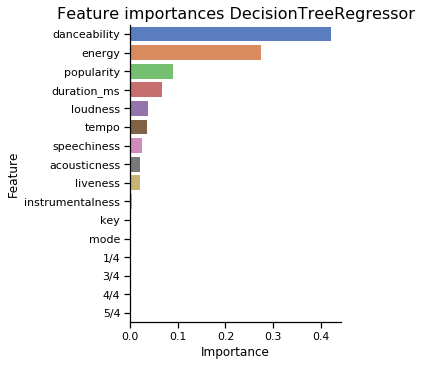

In [0]:
plot_feature_importances(dtr)

### Random Forest Regressor

#### Improving Parameters
Since a Random Forest is made out of Decision Trees, we don't need to improve those features

##### Bootstrap

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   6 | elapsed:    7.1s remaining:   35.5s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   10.1s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   13.7s finished


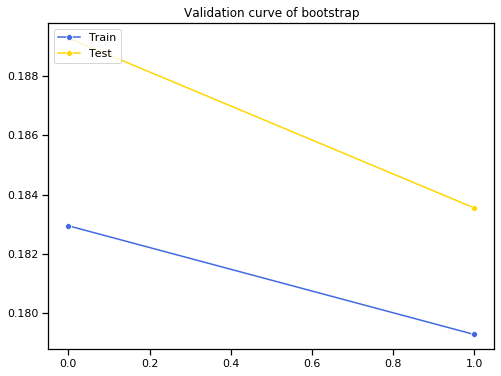

In [0]:
rfr=RandomForestRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, random_state=42)

param_name='bootstrap'
param_range = [False, True]
scoring='neg_mean_squared_error'

rfr_curve=validation_curve(rfr,train_prepared,train_labels,scoring=scoring,cv=3,param_name=param_name,
    param_range=param_range,n_jobs=-1, verbose=3)

plot_validation_curve(rfr_curve,param_range,param_name,scoring)

In this graph, 0 stands for False and 1 stands for True for **bootstrap**. We can clearly see that True gives better results for both the train and test set.

##### Grid Search with the found parameters

In [0]:
rfr=RandomForestRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, bootstrap = True,random_state=42)

param_grid={
    'n_estimators':[100,500],
    #'max_depth':range(4,11),
    #'max_features':[20,23,25],
    #'min_samples_split':[300,500]
}
scoring='neg_mean_squared_error'

rfr_grid=GridSearchCV(rfr,param_grid,scoring=scoring,n_jobs=-1,cv=3, verbose=3)
rfr_grid.fit(train_prepared,train_labels)
print(rfr_grid.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   52.7s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.4min finished


{'n_estimators': 500}


##### N_estimators

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  1.3min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  3.5min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  5.2min finished


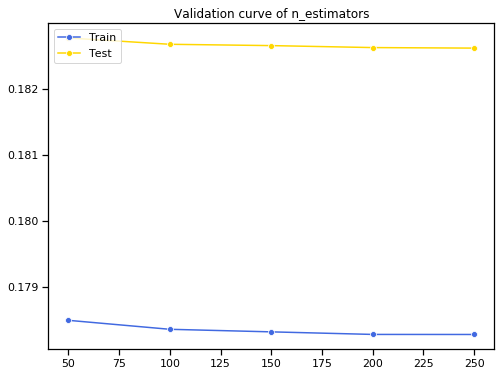

In [0]:
rfr=RandomForestRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, bootstrap = True, random_state=42)

param_name='n_estimators'
param_range = range(50,251,50)
scoring='neg_mean_squared_error'

rfr_curve=validation_curve(rfr,train_prepared,train_labels,scoring=scoring,cv=3,param_name=param_name,
    param_range=param_range,n_jobs=-1, verbose=3)

plot_validation_curve(rfr_curve,param_range,param_name,scoring)

#### Scoring with optimal parameters

In [0]:
rfr=RandomForestRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, bootstrap=True, n_estimators=150,random_state=42)
display_scores(rfr, 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.4min


-----------------------
Scoring: neg_mean_squared_error
Scores: [0.18307182 0.18207173 0.1812688  0.18221209 0.1814011 ]
Mean: 0.18200510780082851
Standard deviation: 0.0006468579236159242
-----------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


#### Feature Importances

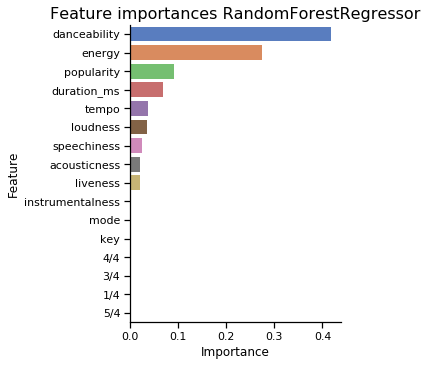

In [0]:
plot_feature_importances(rfr)

### Gradient Boosting Regressor


#### Improving Parameters
Since a Gradient Boosting Regressor is also made out of trees, we can just leave those parameters aswell.

##### Learning_rate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  6.4min remaining: 17.5min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 15.9min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 19.9min finished


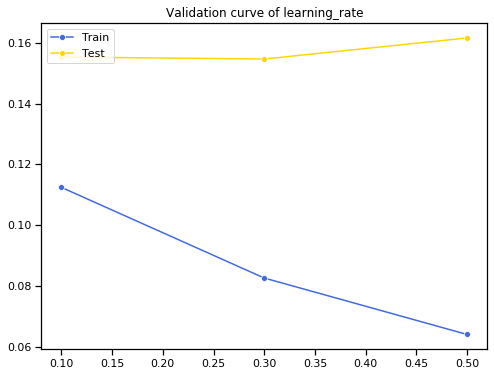

In [0]:
gbr=GradientBoostingRegressor(max_depth= 10, random_state=42)

param_name='learning_rate'
param_range = [0.1, 0.3, 0.5]
scoring='neg_mean_squared_error'

gbr_curve=validation_curve(gbr,train_prepared,train_labels,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1, verbose=3)

plot_validation_curve(gbr_curve,param_range,param_name,scoring)

0.1 seems to be the best value for **learning_rate** to avoid the model starting to overfit to the training data.

##### N_estimators

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:  6.2min remaining: 13.1min
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed: 12.3min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 18.1min finished


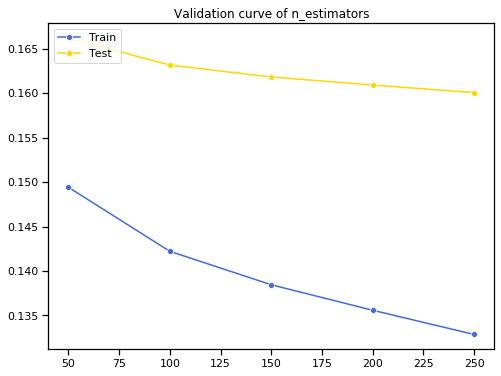

In [0]:
gbr=GradientBoostingRegressor(max_depth= 10, max_features=16, min_samples_split=300,random_state=42)

param_name='n_estimators'
param_range = range(50,251,50)
scoring='neg_mean_squared_error'

gbr_curve=validation_curve(gbr,train_prepared,train_labels,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1, verbose=3)

plot_validation_curve(gbr_curve,param_range,param_name,scoring)

##### Grid Search with the found parameters

In [0]:
gbr=GradientBoostingRegressor(max_depth= 10, max_features=16, min_samples_split=300,random_state=42)

param_grid={
    'n_estimators':[50,100, 150],
    'learning_rate':[0.1, 0.3]  
}
scoring='neg_mean_squared_error'

gbr_grid=GridSearchCV(gbr,param_grid,scoring=scoring,n_jobs=-1,cv=3,verbose=3)
gbr_grid.fit(train_prepared,train_labels)
print(gbr_grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  6.3min finished


{'learning_rate': 0.3, 'n_estimators': 150}


#### Scoring with optimal parameters

In [0]:
gbr=GradientBoostingRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, n_estimators=100,random_state=42)
display_scores(gbr, 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.2min


-----------------------
Scoring: neg_mean_squared_error
Scores: [0.1662966  0.16498917 0.16413317 0.16409278 0.16373823]
Mean: 0.16464999187622534
Standard deviation: 0.0009203557646025436
-----------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min finished


#### Feature Importances

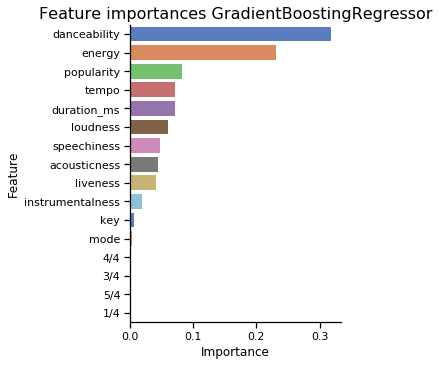

In [0]:
plot_feature_importances(gbr)

### Extra Trees Regressor

#### Improving parameters

Since an Extra Trees Regressor is made out of Decision Trees, we don't need to improve these parameters either.

##### N_estimators

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:   56.0s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:  2.0min remaining:   55.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.9min finished


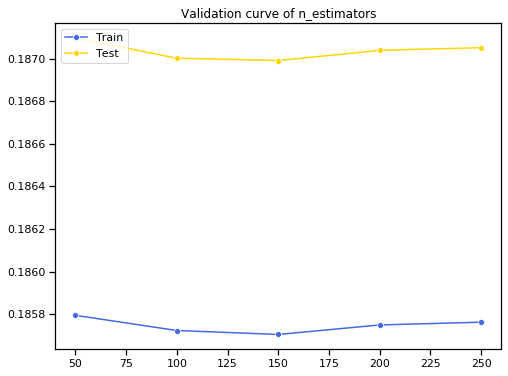

In [0]:
etr=ExtraTreesRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, random_state=42)

param_name='n_estimators'
param_range = range(50,251,50)
scoring='neg_mean_squared_error'

etr_curve=validation_curve(etr,train_prepared,train_labels,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1, verbose=3)

plot_validation_curve(etr_curve,param_range,param_name,scoring)

#### Scoring with optimal paremeters

In [0]:
etr=ExtraTreesRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, bootstrap=True, n_estimators=150,random_state=42)
display_scores(etr, 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.2s remaining:   28.8s


-----------------------
Scoring: neg_mean_squared_error
Scores: [0.18894044 0.18825538 0.1879214  0.18770943 0.1872018 ]
Mean: 0.18800568794315073
Standard deviation: 0.0005791768352159307
-----------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.0s finished


#### Feature importances

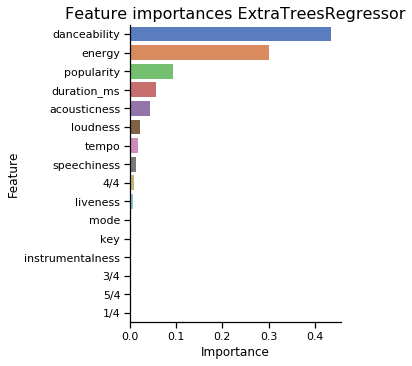

In [0]:
plot_feature_importances(etr)

### Support Vector Machine

#### Improving Parameters

##### C

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:   31.0s remaining:   57.6s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:   56.2s remaining:   24.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.4min finished


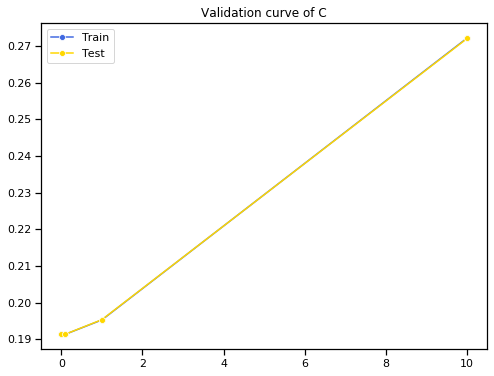

In [0]:
svr=LinearSVR()

param_name='C'
param_range = [0.001, 0.1, 1, 10]
scoring='neg_mean_squared_error'

svr_curve=validation_curve(svr,train_prepared,train_labels,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1, verbose=3)
plot_validation_curve(svr_curve,param_range,param_name,scoring)

Both the training error and testing error become worse equally by increasing te value of **C**. Therefore, 0.001 is the best value.

##### Epsilon

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:   53.8s remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:  1.8min remaining:   49.9s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.2min finished


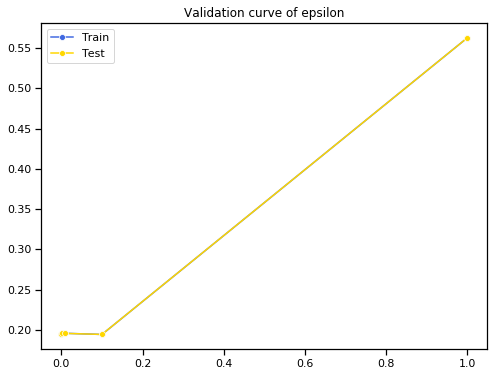

In [0]:
svr=LinearSVR()

param_name='epsilon'
param_range = [0, 0.001, 0.01, 0.1, 1]
scoring='neg_mean_squared_error'

svr_curve=validation_curve(svr,train_prepared,train_labels,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1, verbose=3)
plot_validation_curve(svr_curve,param_range,param_name,scoring)

Just like with C, the error score for both parts increases equally by **Epsilon**. 0 is the best value aswell here.

#### Scoring with optimal parameters

In [0]:
svr = LinearSVR(C=0.001)
display_scores(svr, 5)
display_scores(svr, 5, 'r2')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


-----------------------
Scoring: neg_mean_squared_error
Scores: [0.19259961 0.19119077 0.1909004  0.19151837 0.19048406]
Mean: 0.19133864363615946
Standard deviation: 0.0007164609165133245
-----------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-----------------------
Scoring: r2
Scores: [0.61717355 0.62984604 0.63170224 0.62932656 0.63090234]
Mean: 0.6277901468176464
Standard deviation: 0.005371956364562385
-----------------------


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


### XGBoost

#### Improving parameters

##### Learning_rate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:   13.6s remaining:   29.0s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   29.6s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   36.9s finished


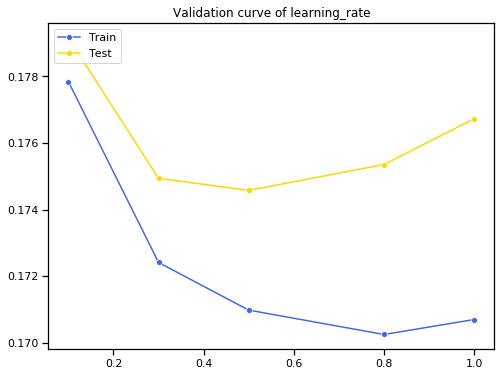

In [0]:
xgb  = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror', tree_method='gpu_hist')

param_name='learning_rate'
param_range = [0.1, 0.3, 0.5, 0.8, 1]
scoring='neg_mean_squared_error'

gbr_curve=validation_curve(xgb,train_prepared,train_labels,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1, verbose=3)

plot_validation_curve(gbr_curve,param_range,param_name,scoring)

0.5 seems to be the best value for **learning_rate** before the scores start diverging too much due to the model overfitting to the training data.

##### Max_depth

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:  8.6min remaining: 16.7min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 out of  50 | elapsed: 16.3min remaining:  7.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 25.8min finished


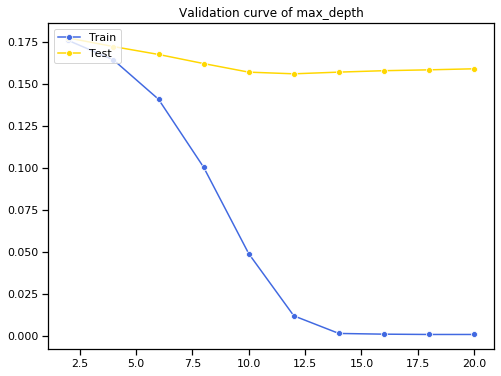

In [0]:
xgb  = XGBRegressor(learning_rate=0.5, random_state=42, n_jobs=-1, objective='reg:squarederror', tree_method='gpu_hist')

param_name='max_depth'
param_range = range(2,21,2)
scoring='neg_mean_squared_error'

gbr_curve=validation_curve(xgb,train_prepared,train_labels,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1, verbose=3)

plot_validation_curve(gbr_curve,param_range,param_name,scoring)

By increasing the **max_depth** for more than 3, the model will drastically overfit to the training data to the point that the error score becomes 0.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:   18.5s remaining:   39.3s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   36.7s remaining:   17.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   51.7s finished


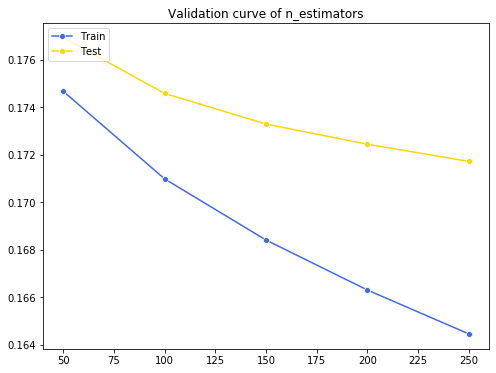

In [0]:
xgb = XGBRegressor(learning_rate=0.5, max_depth=3, objective='reg:squarederror', random_state=42, n_jobs=-1, tree_method='gpu_hist') 

param_name='n_estimators'
param_range = range(50,251,50)
scoring='neg_mean_squared_error'

xgb_curve=validation_curve(xgb,train_prepared,train_labels,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1, verbose=3)

plot_validation_curve(xgb_curve,param_range,param_name,scoring)

#### Scoring with optimal parameters

In [0]:
xgb = XGBRegressor(learning_rate=0.5, max_depth=3, n_estimators=100, objective='reg:squarederror', random_state=42, n_jobs=-1, tree_method='gpu_hist') 
xgb.fit(train_prepared, train_labels)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [0]:
display_scores(xgb, 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.7s remaining:   11.5s


-----------------------
Scoring: neg_mean_squared_error
Scores: [0.17602638 0.17489309 0.17356124 0.17445706 0.17394995]
Mean: 0.1745775452100637
Standard deviation: 0.0008532244983449384
-----------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished


### Voting Regression

In a Voting Regression the model will take the average of all the predictions of the models that are part of it.

In [0]:
svr = LinearSVR(C=0.001)
lr = LinearRegression()
gbr = GradientBoostingRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, n_estimators=100,random_state=42)
rfr = RandomForestRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, bootstrap=True, n_estimators=150,random_state=42)
etr = ExtraTreesRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, bootstrap=True, n_estimators=150,random_state=42)
xgb = XGBRegressor(learning_rate=0.5, max_depth=3, n_estimators=100, objective='reg:squarederror', random_state=42, n_jobs=-1, tree_method='gpu_hist') 

In [0]:
models=[('svr', svr), ('lr', lr),('gbr', gbr), ('rfr', rfr), ('etr', etr), ("xgb", xgb)]
voting_reg = VotingRegressor(models, n_jobs=-1)

In [0]:
display_scores(voting_reg, 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.3min remaining:  6.5min


-----------------------
Scoring: neg_mean_squared_error
Scores: [0.17821817 0.17709606 0.17644865 0.17673303 0.17609808]
Mean: 0.1769187979403434
Standard deviation: 0.0007278601747450465
-----------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.4min finished


#### Stacking/Blending

##### Split the training set into 2 subsets

In [0]:
train_set = strat_train_set.copy()

In [0]:
train_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_8_index, train_2_index in split.split(train_set, train_set["genre"]):
    train_set_8 = df.loc[train_8_index]
    train_set_2 = df.loc[train_2_index]

In [0]:
train_prep_8, train_8_labels, train_8_scaled_labels = DataSetPreparer(train_set_8, test=True) #Set to True so it won't be influenced by the new subsets
train_prep_2, train_2_labels, train_2_scaled_labels = DataSetPreparer(train_set_2, test=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_laun

##### Stacking using vecstack package

In [0]:
models = [
    LinearSVR(C=0.001),
    LinearRegression(),
    GradientBoostingRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, n_estimators=100,random_state=42),
    RandomForestRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, bootstrap=True, n_estimators=150,random_state=42),
    ExtraTreesRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, bootstrap=True, n_estimators=150,random_state=42)
]

In [0]:
S_train, S_test = stacking(models,                   
                           train_prep_8, 
                           train_8_labels, 
                           train_prep_2,   
                           regression=True, 
                           mode='oof_pred_bag',    
                           needs_proba=False,      
                           save_dir=None,            
                           metric=mean_squared_error,    
                           n_folds=4,                  
                           stratified=True,
                           shuffle=True,  
                           random_state=42,    
                           verbose=2)

/usr/local/lib/python3.6/dist-packages/vecstack/core.py:461: UserWarning: This is regression task hence classification-specific parameters set to <True> were ignored: <stratified>
  warnings.warn(warn_str, UserWarning)


task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [LinearSVR]
    fold  0:  [0.03659557]
    fold  1:  [0.03681807]
    fold  2:  [0.03640574]
    fold  3:  [0.03733087]
    ----
    MEAN:     [0.03678756] + [0.00034596]
    FULL:     [0.03678756]

model  1:     [LinearRegression]
    fold  0:  [0.03634386]
    fold  1:  [0.03657175]
    fold  2:  [0.03616109]
    fold  3:  [0.03706513]
    ----
    MEAN:     [0.03653546] + [0.00033865]
    FULL:     [0.03653546]

model  2:     [GradientBoostingRegressor]
    fold  0:  [0.02734853]
    fold  1:  [0.02762505]
    fold  2:  [0.02749339]
    fold  3:  [0.02805733]
    ----
    MEAN:     [0.02763108] + [0.00026482]
    FULL:     [0.02763107]

model  3:     [RandomForestRegressor]
    fold  0:  [0.03297928]
    fold  1:  [0.03365450]
    fold  2:  [0.03324475]
    fold  3:  [0.03410627]
    ----
    MEAN:     [0.03349620] + [0.00042652]
    FULL:     [0.03349620]

mod

Optimizing second level model

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:    8.8s remaining:   18.8s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   17.0s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   20.9s finished


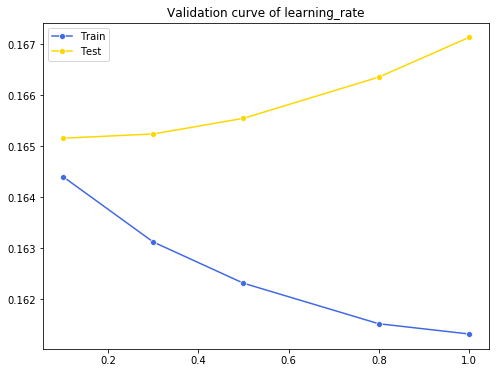

In [0]:
xgb  = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror', tree_method='gpu_hist')

param_name='learning_rate'
param_range = [0.1, 0.3, 0.5, 0.8, 1]
scoring='neg_mean_squared_error'

gbr_curve=validation_curve(xgb,S_train,train_8_labels,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1, verbose=3)

plot_validation_curve(gbr_curve,param_range,param_name,scoring)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:  9.5min remaining: 18.4min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 out of  50 | elapsed: 19.4min remaining:  9.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 34.3min finished


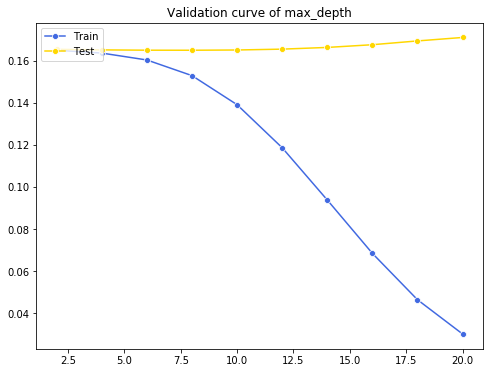

In [0]:
xgb  = XGBRegressor(learning_rate=0.1, random_state=42, n_jobs=-1, objective='reg:squarederror', tree_method='gpu_hist')

param_name='max_depth'
param_range = range(2,21,2)
scoring='neg_mean_squared_error'

gbr_curve=validation_curve(xgb,S_train,train_8_labels,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1, verbose=3)

plot_validation_curve(gbr_curve,param_range,param_name,scoring)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:   10.7s remaining:   22.8s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   20.1s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   27.8s finished


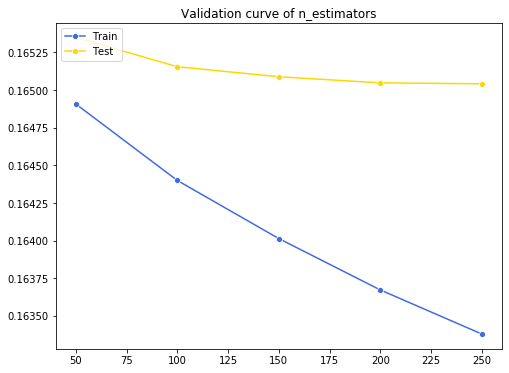

In [0]:
xgb = XGBRegressor(learning_rate=0.1, max_depth=3, objective='reg:squarederror', random_state=42, n_jobs=-1, tree_method='gpu_hist') 

param_name='n_estimators'
param_range = range(50,251,50)
scoring='neg_mean_squared_error'

xgb_curve=validation_curve(xgb,S_train,train_8_labels,scoring=scoring,cv=5,param_name=param_name,
    param_range=param_range,n_jobs=-1, verbose=3)

plot_validation_curve(xgb_curve,param_range,param_name,scoring)

In [0]:
xgb  = XGBRegressor(learning_rate=0.1,max_depth=3, random_state=42, n_estimators=100, n_jobs=-1, objective='reg:squarederror', tree_method='gpu_hist')
display_scores(xgb, 10, data=S_train, labels=train_8_labels)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    8.1s remaining:    3.5s


-----------------------
Scoring: neg_mean_squared_error
Scores: [0.16558546 0.16277164 0.16504345 0.16528473 0.16469223 0.16546478
 0.16632221 0.16299944 0.16686495 0.16629069]
Mean: 0.16513195784347637
Standard deviation: 0.0012814968849651058
-----------------------


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.6s finished


##### Stacking using the ML-Ensemble package

In [0]:
ensemble = SuperLearner(scorer=rmse, random_state=42, verbose=5, n_jobs=-1)

In [0]:
ensemble.add(models)

SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...8a16268>)],
   n_jobs=-1, name='group-0', raise_on_exception=True, transformers=[])],
   verbose=4)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20,
       scorer=<function rmse at 0x7f0758a16268>, shuffle=False, verbose=5)

In [0]:
ensemble.add_meta(XGBRegressor(learning_rate=0.5, max_depth=3, n_estimators=100, objective='reg:squarederror', random_state=42, n_jobs=-1, tree_method='gpu_hist'))

SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...8a16268>)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=4)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20,
       scorer=<function rmse at 0x7f0758a16268>, shuffle=False, verbose=5)

In [0]:
ensemble.fit(train_prepared, train_labels)


Fitting 2 layers
[INFO] n_jobs = -1
[INFO] backend = 'threading'
[INFO] start_method = 'fork'
[INFO] cache = '/tmp'

Processing layer-1            
Learners ...                  
extratreesregressor.0.2        done | 00:00:11
extratreesregressor.0.1        done | 00:00:11
extratreesregressor.0.0        done | 00:00:23
linearregression.0.0           done | 00:00:00
linearregression.0.1           done | 00:00:00
linearregression.0.2           done | 00:00:00
linearsvr.0.0                  done | 00:00:00
linearsvr.0.1                  done | 00:00:00
linearsvr.0.2                  done | 00:00:00
gradientboostingregressor.0.1  done | 00:00:55
gradientboostingregressor.0.2  done | 00:00:58
randomforestregressor.0.1      done | 00:00:57
randomforestregressor.0.2      done | 00:00:55
randomforestregressor.0.0      done | 00:01:55
gradientboostingregressor.0.0  done | 00:02:20
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.3min finished
done | 00:02:20
layer-1                     

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


xgbregressor.0.0               done | 00:00:00
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
done | 00:00:00
layer-2                        done | 00:00:00
Fit complete                        | 00:02:21


SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...63d5268>)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=4)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20,
       scorer=<function rmse at 0x7f05363d5268>, shuffle=False, verbose=5)

In [0]:
pred = ensemble.predict(train_prepared)


Predicting 2 layers
[INFO] n_jobs = -1
[INFO] backend = 'threading'
[INFO] start_method = 'fork'
[INFO] cache = '/tmp'

Processing layer-1            
Learners ...                  
linearsvr.0.0                  done | 00:00:00linearregression.0.0           done | 00:00:00

gradientboostingregressor.0.0  done | 00:00:00
extratreesregressor.0.0        done | 00:00:01
randomforestregressor.0.0      done | 00:00:02
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
done | 00:00:02
layer-1                        done | 00:00:02
Processing layer-2            
Learners ...                  
xgbregressor.0.0               done | 00:00:00
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
done | 00:00:00
layer-2                        done | 00:00:00
Predict complete                    | 00:00:02


In [0]:
mean_squared_error(train_labels, pred)

0.021140992182632243

### Scoring the models on the stratified test set
After we evaluated and fine-tuned all our models it is time to score them on our stratified test set to see how well they will perform on unseen data.

*Starting with a fresh copy of the test set*

In [0]:
test_set = strat_test_set.copy()

In [0]:
test_set.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
122173,Rap,Mike WiLL Made-It,On The Come Up (feat. Big Sean),7HwKzQBybHSHqdLv25VdtU,52,0.0391,0.494,235886,0.643,0.000,G,0.6580,-6.211,Major,0.2940,110.052,4/4,0.511
59834,R&B,Cuban Doll,Let It Blow (feat. Molly Brazy),2zG54F3cASuj6yHoYeCoK6,51,0.0145,0.730,159843,0.701,0.000,A,0.0795,-5.912,Major,0.3460,179.763,4/4,0.307
55521,Movie,Judy Kuhn,Goodby Joe,7BSkcOETKiHTVzCnKx5jdM,1,0.7910,0.794,145653,0.328,0.000,C,0.1490,-7.723,Major,0.0358,121.869,4/4,0.413
80883,Opera,Adolphe Adam,Giselle: Act I: Moderato,3gbf9PJnMLR0mNXNApx1UF,10,0.8720,0.404,62693,0.187,0.432,D#,0.1000,-23.432,Major,0.0583,173.534,4/4,0.375
66857,Hip-Hop,"Tyler, The Creator",Potato Salad,1jzIJcHCXneHw7ojC6LXiF,76,0.3080,0.538,182493,0.612,0.000,D,0.2130,-6.020,Major,0.4240,168.197,4/4,0.684


#### Prepare the test data and labels using the pipelines

In [0]:
test_prepared, test_labels, test_scaled_labels = DataSetPreparer(test_set, test = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_laun

In [0]:
test_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26742 entries, 0 to 26741
Data columns (total 16 columns):
popularity          26742 non-null float64
acousticness        26742 non-null float64
danceability        26742 non-null float64
duration_ms         26742 non-null float64
energy              26742 non-null float64
instrumentalness    26742 non-null float64
liveness            26742 non-null float64
loudness            26742 non-null float64
speechiness         26742 non-null float64
tempo               26742 non-null float64
key                 26742 non-null float64
mode                26742 non-null float64
1/4                 26742 non-null float64
3/4                 26742 non-null float64
4/4                 26742 non-null float64
5/4                 26742 non-null float64
dtypes: float64(16)
memory usage: 3.3 MB


#### Score the different models on the prepared test data


In [0]:
def display_test_score(train_predict, test_predict, fit_pred_time):
    mse=mean_squared_error(train_labels,train_predict)
    train_rmse=np.sqrt(mse)

    mse=mean_squared_error(test_labels,test_predict)
    test_rmse=np.sqrt(mse)
    
    data = {'Train error' : [train_rmse], "Test error" : [test_rmse], "Time (sec)" : [fit_pred_time]}
    return pd.DataFrame(data)

#### Decision Tree Regressor

In [0]:
dtr=DecisionTreeRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100 ,random_state=42)

In [0]:
dtr_t = time()
dtr.fit(train_prepared,train_labels)
dtr_train_pred=dtr.predict(train_prepared)
dtr_test_pred=dtr.predict(test_prepared)
dtr_t2 = time() - dtr_t

In [0]:
dtr_score_df = display_test_score(dtr_train_pred, dtr_test_pred, dtr_t2)
print(dtr_score_df)

   Train error  Test error  Time (sec)
0     0.182629     0.18724    0.848287


#### Random Forest Regressor

In [0]:
rfr=RandomForestRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, bootstrap=True, n_estimators=150,random_state=42)

In [0]:
rfr_t = time()
rfr.fit(train_prepared,train_labels)
rfr_train_pred=rfr.predict(train_prepared)
rfr_test_pred=rfr.predict(test_prepared)
rfr_t2 = time() - rfr_t

In [0]:
rfr_score_df = display_test_score(rfr_train_pred, rfr_test_pred, rfr_t2)
print(rfr_score_df)

   Train error  Test error  Time (sec)
0      0.17746    0.180897   79.591579


#### Gradient Boosting Regressor

In [0]:
gbr=GradientBoostingRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, n_estimators=100,random_state=42)

In [0]:
gbr_t = time()
gbr.fit(train_prepared,train_labels)
gbr_train_pred=gbr.predict(train_prepared)
gbr_test_pred=gbr.predict(test_prepared)
gbr_t2 = time() - gbr_t

In [0]:
gbr_score_df = display_test_score(gbr_train_pred, gbr_test_pred, gbr_t2)
print(gbr_score_df)

   Train error  Test error  Time (sec)
0     0.147723    0.164524   84.757576


#### Support Vector Machine

In [0]:
svr=LinearSVR(C=0.001)

In [0]:
svr_t = time()
svr.fit(train_prepared,train_labels)
svr_train_pred=svr.predict(train_prepared)
svr_test_pred=svr.predict(test_prepared)
svr_t2 = time() - svr_t

In [0]:
svr_score_df = display_test_score(svr_train_pred, svr_test_pred, svr_t2)
print(svr_score_df)

   Train error  Test error  Time (sec)
0     0.191266    0.190765    0.213061


#### Extra Trees Regressor

In [0]:
etr = ExtraTreesRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, bootstrap=True, n_estimators=150,random_state=42)

In [0]:
etr_t = time()
etr.fit(train_prepared,train_labels)
etr_train_pred=etr.predict(train_prepared)
etr_test_pred=etr.predict(test_prepared)
etr_t2 = time() - etr_t

In [0]:
etr_score_df = display_test_score(etr_train_pred, etr_test_pred, etr_t2)
print(etr_score_df)

   Train error  Test error  Time (sec)
0     0.186462    0.186886   13.615593


#### XGBoost

In [0]:
xgb = XGBRegressor(learning_rate=0.5, max_depth=3, n_estimators=100, objective='reg:squarederror', random_state=42, n_jobs=-1, tree_method='gpu_hist')

In [0]:
xgb_t = time()
xgb.fit(train_prepared,train_labels)
xgb_train_pred=xgb.predict(train_prepared)
xgb_test_pred=xgb.predict(test_prepared)
xgb_t2 = time() - xgb_t

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [0]:
xgb_score_df = display_test_score(xgb_train_pred, xgb_test_pred, xgb_t2)
print(xgb_score_df)

   Train error  Test error  Time (sec)
0     0.171469    0.174653    1.665097


#### Voting Regressor

In [0]:
models=[('svr', svr), ('gbr', gbr), ('rfr', rfr), ('etr', etr), ("xgb", xgb)]
voting_reg = VotingRegressor(models, n_jobs=-1)

In [0]:
vr_t = time()
voting_reg.fit(train_prepared,train_labels)
voting_reg_train_pred = voting_reg.predict(train_prepared)
voting_reg_test_pred = voting_reg.predict(test_prepared)
vr_t2 = time() - vr_t

In [0]:
voting_reg_score_df = display_test_score(voting_reg_train_pred, voting_reg_test_pred, vr_t2)
print(voting_reg_score_df)

   Train error  Test error  Time (sec)
0     0.169673    0.174331   95.471367


#### Stacking with vecstack

In [0]:
models = [
    LinearSVR(C=0.001),
    LinearRegression(),
    GradientBoostingRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, n_estimators=100,random_state=42),
    RandomForestRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, bootstrap=True, n_estimators=150,random_state=42),
    ExtraTreesRegressor(max_depth= 10, max_features=16, min_samples_split=300, min_samples_leaf=100, bootstrap=True, n_estimators=150,random_state=42)
]

In [0]:
vec_t = time()
S_train, S_test = stacking(models,                   
                           train_prepared, 
                           train_labels, 
                           test_prepared,   
                           regression=True, 
                           mode='oof_pred_bag',    
                           needs_proba=False,      
                           save_dir=None,            
                           metric=mean_squared_error,    
                           n_folds=4,                  
                           stratified=True,
                           shuffle=True,  
                           random_state=42,    
                           verbose=2)
vec_t2 = time() - vec_t

/usr/local/lib/python3.6/dist-packages/vecstack/core.py:461: UserWarning: This is regression task hence classification-specific parameters set to <True> were ignored: <stratified>
  warnings.warn(warn_str, UserWarning)


task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [LinearSVR]
    fold  0:  [0.03677688]
    fold  1:  [0.03655190]
    fold  2:  [0.03659798]
    fold  3:  [0.03651539]
    ----
    MEAN:     [0.03661053] + [0.00010040]
    FULL:     [0.03661053]

model  1:     [LinearRegression]
    fold  0:  [0.03653814]
    fold  1:  [0.03633357]
    fold  2:  [0.03633878]
    fold  3:  [0.03620601]
    ----
    MEAN:     [0.03635413] + [0.00011880]
    FULL:     [0.03635413]

model  2:     [GradientBoostingRegressor]
    fold  0:  [0.02754029]
    fold  1:  [0.02711945]
    fold  2:  [0.02736788]
    fold  3:  [0.02715731]
    ----
    MEAN:     [0.02729623] + [0.00016974]
    FULL:     [0.02729623]

model  3:     [RandomForestRegressor]
    fold  0:  [0.03335929]
    fold  1:  [0.03314777]
    fold  2:  [0.03332133]
    fold  3:  [0.03313541]
    ----
    MEAN:     [0.03324095] + [0.00010036]
    FULL:     [0.03324095]

mod

In [0]:
vec  = XGBRegressor(learning_rate=0.1, max_depth=3, random_state=42, n_estimators=100, n_jobs=-1, objective='reg:squarederror', tree_method='gpu_hist')

In [0]:
vec_t3 = time()
vec.fit(S_train,train_labels)
vec_train_pred=vec.predict(S_train)
vec_test_pred=vec.predict(S_test)
vec_t4 = (time() - vec_t3) + vec_t2

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [0]:
vec_score_df = display_test_score(vec_train_pred, vec_test_pred, vec_t4)
print(vec_score_df)

   Train error  Test error  Time (sec)
0     0.163609    0.163814  498.107648


#### Stacking with ML-ens

In [0]:
ensemble = SuperLearner(scorer=rmse, random_state=42, verbose=5, n_jobs=-1)

In [0]:
ensemble.add(models)
ensemble.add_meta(XGBRegressor(learning_rate=0.5, max_depth=3, n_estimators=100, objective='reg:squarederror', random_state=42, n_jobs=-1, tree_method='gpu_hist'))

SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...8a16268>)],
   n_jobs=-1, name='group-5', raise_on_exception=True, transformers=[])],
   verbose=4)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20,
       scorer=<function rmse at 0x7f0758a16268>, shuffle=False, verbose=5)

In [0]:
ens_t = time()
ensemble.fit(train_prepared, train_labels)
ens_train_pred=ensemble.predict(train_prepared)
ens_test_pred=ensemble.predict(test_prepared)
ens_t2 = time() - ens_t


Fitting 2 layers
[INFO] n_jobs = -1
[INFO] backend = 'threading'
[INFO] start_method = 'fork'
[INFO] cache = '/tmp'

Processing layer-1            
Learners ...                  
extratreesregressor.0.2        done | 00:00:11
extratreesregressor.0.1        done | 00:00:11
extratreesregressor.0.0        done | 00:00:23
linearregression.0.0           done | 00:00:00
linearregression.0.1           done | 00:00:00
linearregression.0.2           done | 00:00:00
linearsvr.0.0                  done | 00:00:00
linearsvr.0.1                  done | 00:00:00
linearsvr.0.2                  done | 00:00:00
gradientboostingregressor.0.1  done | 00:00:53
gradientboostingregressor.0.2  done | 00:00:59
randomforestregressor.0.1      done | 00:00:56
randomforestregressor.0.2      done | 00:00:54
randomforestregressor.0.0      done | 00:01:54
gradientboostingregressor.0.0  done | 00:02:22
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.4min finished
done | 00:02:22
layer-1                     

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


xgbregressor.0.0               done | 00:00:00
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
done | 00:00:00
layer-2                        done | 00:00:00
Fit complete                        | 00:02:23

Predicting 2 layers
[INFO] n_jobs = -1
[INFO] backend = 'threading'
[INFO] start_method = 'fork'
[INFO] cache = '/tmp'

Processing layer-1            
Learners ...                  
linearregression.0.0           done | 00:00:00
linearsvr.0.0                  done | 00:00:00
gradientboostingregressor.0.0  done | 00:00:00
extratreesregressor.0.0        done | 00:00:01
randomforestregressor.0.0      done | 00:00:02
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished
done | 00:00:02
layer-1                        done | 00:00:02
Processing layer-2            
Learners ...                  
xgbregressor.0.0               done | 00:00:00[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

done | 00:00:00
layer-2                 

In [0]:
ens_score_df = display_test_score(ens_train_pred, ens_test_pred, ens_t2)
print(ens_score_df)

   Train error  Test error  Time (sec)
0     0.144842    0.164277  146.453323


#### Compare the scores of the different models

In [0]:
scores = [dtr_score_df,rfr_score_df,gbr_score_df,svr_score_df,etr_score_df,xgb_score_df, voting_reg_score_df, vec_score_df, ens_score_df]
names = ['DTR', 'RFR', 'GBR', 'SVR', 'ETR', 'XGB', 'VR', 'VEC', 'ENS']
scores_df = pd.concat(scores)
scores_df['Model'] = names
scores_df = scores_df.sort_values('Test error', ascending=False)

In [0]:
scores_df.head(10)

,Train error,Test error,Time (sec),Model
0,0.191266,0.190765,0.213061,SVR
0,0.182629,0.187240,0.848287,DTR
0,0.186462,0.186886,13.615593,ETR
0,0.177460,0.180897,79.591579,RFR
0,0.171469,0.174653,1.665097,XGB
0,0.169673,0.174331,95.471367,VR
0,0.147723,0.164524,84.757576,GBR
0,0.144842,0.164277,146.453323,ENS
0,0.163609,0.163814,498.107648,VEC


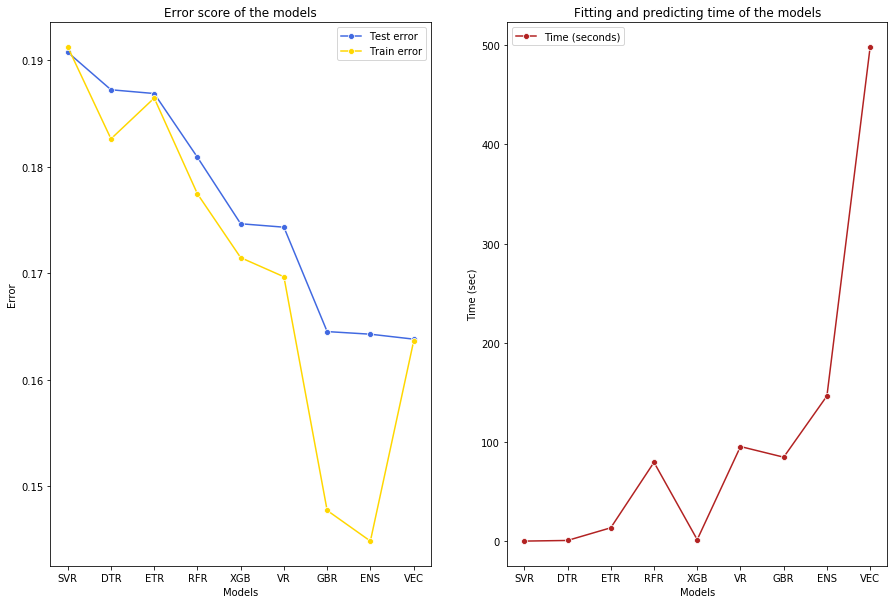

In [0]:
fig, axs = plt.subplots(ncols = 2, figsize=(15,10))
sns.lineplot(data=scores_df, x="Model", y="Test error", color="royalblue", ax=axs[0], label="Test error", sort=False, marker="o")
sns.lineplot(data=scores_df, x="Model", y="Train error", color="gold", ax=axs[0], label="Train error", sort=False, marker="o")
sns.lineplot(data=scores_df, x="Model", y="Time (sec)", color="firebrick", ax=axs[1], label="Time (seconds)", sort=False, marker="o")

axs[0].set_ylabel("Error")
axs[0].set_xlabel("Models")
axs[1].set_xlabel("Models")
axs[0].set_title("Error score of the models")
axs[1].set_title("Fitting and predicting time of the models")
axs[0].legend()
axs[1].legend(loc="upper left")
plt.show()

## 7. Present your solution

The two figures above highlight the different results for the models. It is then possible to pick one model over the others, depending on the users expectations. If time is an important factor in the users decision, it is pretty obvious that the vecstack model, which does give the best error score, does not fit the user needs. It would be more relevant to pick either the ensemble model or the gradient boosting regression model because they give us a sufficient score in a reasonable amount of time. However, if time is not important it is clearly the vecstack model that you should pick for two reasons. First, it gives a slightly better error score than the two previous models. But most importantly, the gap between the train and the test error score is pretty small. This means that we can be more confident about how this model will react on new/unseen data in the future. 

## 8. Launch, monitor and maintain your system

After the our model has been trained and decided, we could upload it to for example Google Cloud AI Platform for other people to use. They can then just use the predict method with data they supply so te model can make a guess on how much the house will cost. An important part though is that we still monitor our model on the accuracy so it won't perform much worse over time. To contain this we could for example train it again regularly with new data and find new parameters to use. Finally we also have to make sure we also have backups of these models for in case one of the newer models has something wrong and we can go back to an older version.